# Ranked Strategic Classification 🦚

## 1. Introduction

In our project we tackle the problem of Strategic classification with user dependant responses. 

We introduce user dependance through competition on $k$ available spots which are given to the top-k rated users.

This problem appears in our daily life in multiple places such as acceptance into universities and job interviews, where the users compete for a few available spots.

These users are strategic, meaning they can improve their rating by changing their features to move up the ranking and get accepted. In the example of a job interview, they can for example create a specialized CV which they know will help them in getting the job.

# TODO for submition   
Code and introduction is pretty well aranged, the main thing is to arange the results and draw conclusions.
Summarize 3 main experiments:
1. Stategic Vs. Non-Strategic 
2. Different contest parameters
3. Individual Scales

### Remaining:
- ellaborate more about each experiment + results
- ~Change experiments to non-strategic model and say that we tested both and choose non-strategic.~

### 1.1 Goals
In this project, our goals are:

🦚 Developing a system capable of coping with contest behavior.

🦚 Deploying the system on toy example with synthetic data.

🦚 Exploring accuracy-burden trade-off with different contest parameters.

🦚 Exploring potential pitifalls of the system, where it fails and where it succeeds.

 ### 1.2 Setting
- Time is assumed to be discrete and denoted by $t\in\{0,1,...\}$
- Each user $i$ has initial features $x_i(0)\in \mathbb{R}^d$
- Each user $i$ updates his features at each time $t$ with a function $x_i(t) = \Delta_h(x_i(0))$.
  
<ins>Note:</ins> For simplification, the user always updates his features based on his features at $t=0$.
- The set of user features at time $t$ is denoted by $X_t$
- Each user has a ground truth rating $r(x_i(0))$
- The model predicted ratings are denoted by $r_{\theta}(x_i(t))$. We train a model to predict the true ratings using an MSE loss $\ell(r(x_i(0)),r_{\theta}(x_i(t))) = \lVert r(x_i(0)) - r_{\theta}(x_i(t)) \rVert ^2 $. 
- Denote the sorted indices of the users based on $r_{\theta}(x_i(t))$ by $s_i(t) = \text{argsort}(\{r_\theta(x(t))\}_{x(t)\in X_t})[i]$

Given all of the users and their features, the system predicts the rating for each user, $r_\theta(x_i(t))$, and accepts the top-$k$ rated users $\{x_{s_1(t)},...,x_{s_k(t)}\}$. 



In [21]:
# TODO: after we finish all experiments remove redundant imports
%matplotlib notebook
%matplotlib inline
import cvxpy as cp
import copy
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import zero_one_loss, confusion_matrix
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
import json
import random
import math
import os, psutil
from datetime import datetime
from sklearn.metrics import ndcg_score, precision_score, recall_score, mean_squared_error

X_LOWER_BOUND = -10
X_UPPER_BOUND = 10
SEED = 12
VERBOSE = False

torch.set_default_dtype(torch.float64)
torch.manual_seed(SEED)
np.random.seed(SEED)


## make plots prettier 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'

### 1.3 Strategic Behavior Model

We model the behavior based on the paper: *S. Levanon, N. Rosenfeld: "Strategic Classification Made Practical", 2021*

We assume a behavioral model for the user strategic response $\Delta_h(\cdot)$. Given the ratings at time $t$ we calculate 2 thresholds:

$$
T_{low} = r_\theta(x_{s_k(t)}(t)), \quad T_{high} = r_\theta(x_{s_{k'}(t)}(t)) 
$$

Where $k'< k$ is a positive integer. These thresholds are used to model the behavioral responses. 

We hypothesize that users will not be satisfied by barely passing the low threshold and will want acceptance confidence, i.e. will want to be further from the lower acceptance rate and closer to some higher rating threshold. Using this we design the following reward function: 

$$h(r;\phi) = q\cdot\sigma^*_{\tau}\left(\frac{r-T_{low}}{\tau_{low}}\right) + (1-q)\cdot\sigma^*_{\tau}\left(\frac{r-T_{high}}{\tau_{high}}\right)$$

Where $q\in[0,1]$, and $\sigma(\cdot)$ is a sigmoid function that will be discussed in the CCP section. This gives a reward $q$ for acceptance and the rest is given for passing the higher threshold. $\phi = \{ T_{low},T_{high}, \tau_{low}, \tau_{high}, q\} $ denotes the set of all behavioral parameters which impact the reward function $h$.

The $\tau$ parameters express the softness of threshold; small $\tau$ will give a step like reward and large $\tau$ will give a smoother reward. In the code with use $\text{slope}=\tau^{-1}$ to control this property.

The user responses are modeled as 

$$\Delta_h(x) = \underset{x'}{\text{argmax }} h(r_\theta(x');\phi) - c(x,x')$$

Where $c(\cdot,\cdot)$ is a convex cost function for feature change, we use squared Euclidean distance.

This function for different parameters is plotted below to help understand its properties.

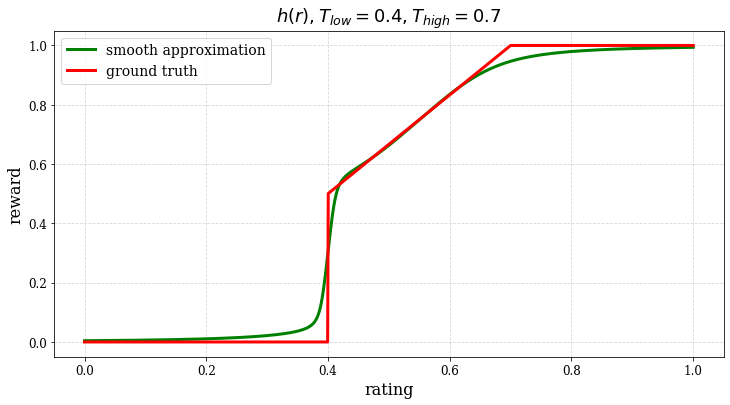

In [22]:
# plotting how the function looks for different contest parameters
def ccp_sigmoid(x, tau):
  return 0.5*np.sqrt(((x/tau + 1) ** 2) + 1) - 0.5*np.sqrt(((x/tau - 1) ** 2) + 1)

def ccp_smooth_f(x, slope_low=50, slope_high=20, T_low=0.4, T_high=0.7, q=0.5):
  return q*ccp_sigmoid(x - T_low, tau=1/slope_low) + (1-q)*ccp_sigmoid(x - T_high, tau=1/slope_high)

def non_smooth_f(r,thresh_low=0.4,thresh_high=0.7, q=0.5):
  h = np.zeros(r.shape)
  h[r > thresh_high] = 1
  mid_idx = np.logical_and(r <= thresh_high, r >= thresh_low)
  h[mid_idx] = (r[mid_idx] - thresh_low)/(thresh_high - thresh_low)*(1-q) + q
  return h

fig, ax = plt.subplots(1,1,figsize=(12,6))
r = np.linspace(0, 1, 1000)
ax.plot(r,0.5*ccp_smooth_f(r, slope_low=100, slope_high=10, T_high=0.55) + 0.5,color='green', label='smooth approximation')
ax.plot(r,non_smooth_f(r, thresh_high=0.7),color='red', label='ground truth')
# ax.plot(r,ccp_smooth_f(r, slope_low=10, slope_high=30),color='purple', label="$\mathrm{slope}_{low}=10$, $\mathrm{slope}_{high}=30$, $q=0.5$")
# ax.plot(r,(ccp_smooth_f(r, slope_low=50, slope_high=50, q=0.7)),color='orange', label='$\mathrm{slope}_{low}=50$, $\mathrm{slope}_{high}=50$, $q=0.7$')
ax.set_xlabel('rating')
ax.set_ylabel('reward')
ax.set_title('$h(r),\t T_{low}=0.4, \t T_{high}=0.7$')
ax.legend()
ax.grid(True)

In the figure above we can see our model for the behavioral response. We present a ground truth model (in red) which is problematic for optimization and a smooth approximation (in green). Both models convey the idea of desired acceptance but lack of statisfaction from laying on the acceptance threshold. That is because the threshold may change from the behavior of other users. 

As presented before both behavioral models contain tunable parameters to account for different behaviors for different constests and for different participants (users) in the contest.


### 1.4 Function Definitions

In this section we implement the score function, as well as a differientiable sigmoid-like function used in the definition of $h$:

$$\sigma_\tau^*(z) = 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1} - 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$$

We denote $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1}$ with $f(z)$ and $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$ with $g(z)$.

Note that both $f(z)$ and $g(z)$ are convex. The maximization target in the response function $\Delta_h(\cdot)$ is a sum of two such sigmoids minus the cost function.

For a convex cost function the target can be expressed as a difference of convex functions. This property allows us to use the CCP method for the optimization. This is an algorithm that uses local 1st order Taylor approximation at each optimization step for the convex part which makes it affine. This provides a local concave approximation of the target function which allows use of solvers for the maximization.

For further reading on CCP refer to *T. Lipp, S. Boyd: "Variations and extension of the convex-concave procedure", 2015*

The functions below are definitions of the functions that compose the target required for the optimization. They are implemented with CVXPY which is the solver we use.


In [23]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope, T):
    return 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b)-T) + 1)]), 2)
    # return 0.5*cp.sqrt(1+cp.square((slope*(score(x, w, b) - T) + 1)))

def g(x, w, b, slope, T):
    res = 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b) - T) - 1)]), 2)
    return res

def c(x, r, x_dim, scale):
    return (scale)*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope, T):
    return 0.5*cp.multiply(slope*((slope*(score(x, w, b)-T) + 1)/cp.sqrt((slope*(score(x, w, b)-T) + 1)**2 + 1)), w)

def f_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones(x.shape[0]), slope*(score(x, w, b) - T) + 1]), 2, axis=0)

def g_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones((1, x.shape[0])), cp.reshape((slope*(score(x, w, b)-T) - 1), (1, x.shape[0]))]), 2, axis=0)

def c_batch(x, r, x_dim, scale):
    return (scale)*cp.square(cp.norm(x-r, 2, axis=1))

def f_derivative_batch(x, w, b, slope, T):
    nablas = 0.5*slope*((slope*(score(x, w, b) - T) + 1)/cp.sqrt((slope*(score(x, w, b) - T) + 1)**2 + 1))
    return cp.reshape(nablas, (nablas.shape[0], 1))@cp.reshape(w, (1, x.shape[1]))

# ------------------------------------- Our added functions -------------------------------------
# summing 2 sigmoids to model initial acceptance and higher acceptance in order to model user behavior of wanting to have some margin from min requirements

def f_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f(x, w, b, slope_high, Thresh_high)

def g_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g(x, w, b, slope_high, Thresh_high)

def f_tot_derivative(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    f_der = cp.pos(acp_reward) * f_derivative(x, w, b, slope_low, Thresh_low) + cp.pos(1-acp_reward) * f_derivative(x, w, b, slope_high, Thresh_high)
    return f_der

def f_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f_batch(x, w, b, slope_high, Thresh_high)

def g_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g_batch(x, w, b, slope_high, Thresh_high)

def f_tot_derivative_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    return acp_reward * f_derivative_batch(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * f_derivative_batch(x, w, b, slope_high, Thresh_high)

# -----------------------------------------------------------------------------------------------

#### Copy of functions in numpy - for line search optimization

In [24]:
def f_np(x, w, b, slope, T):
    s = slope*(score(x, w, b) - T)
    res = 0.5 * np.sqrt(1 + (s + 1) ** 2)
    return res

def g_np(x, w, b, slope, T):
    s = slope*(score(x, w, b) - T)
    res = 0.5 * np.sqrt(1 + (s - 1) ** 2)
    return res

def c_np(x, r, x_dim, scale):
    cost = (scale)*np.sum((x-r) ** 2, 1)
    cost = cost.detach().numpy() if isinstance(cost, torch.Tensor) else cost
    return cost


# ------------------------------------- Our added functions -------------------------------------
# summing 2 sigmoids to model initial acceptance and higher acceptance in order to model user behavior of wanting to have some margin from min requirements

def f_tot_np(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return acp_reward * f_np(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * f_np(x, w, b, slope_high, Thresh_high)

def g_tot_np(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return acp_reward * g_np(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * g_np(x, w, b, slope_high, Thresh_high)


# -----------------------------------------------------------------------------------------------

## 2. Implementation
### 2.1 CCP

Defining a CCP class based on the one implemented in the paper referenced above.

Convex-Concave Procedure (in short CCP) is an iterative method for solving optimization problems that are expressed as a difference of convex functions, like the one we have in our problem.

It does so by iterating through a sequence of concave-relaxed problems (using Taylor series to linearize on of the functions), a process that guarantees convergence to local maxima.

As shown in the previous section the response function $\Delta_h$ is a maximization over a difference of convex functions.

In [25]:
class CCP_rank:
    def __init__(self, x_dim, batch_size, funcs, scale):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        self.batch_size = batch_size

        self.x = cp.Variable((batch_size, x_dim))
        self.xt = cp.Parameter((batch_size, x_dim))
        self.r = cp.Parameter((batch_size, x_dim))
        
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1) # bias parameter

        # -------------------- adding our function's params --------------------
        self.slope_low = cp.Parameter(1) # scale of the low threshold sigmoid
        self.slope_high = cp.Parameter(1) # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = cp.Parameter(1) # defines the reward for passing initial threshhold - q in the equations 
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        target = cp.diag(self.x@(self.f_derivative(self.xt, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward).T)) - self.g(self.x, self.w,
                        self.b, self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward) - self.c(self.x, self.r,
                        x_dim, scale)
        # # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        # define the problem's objective
        self.prob = cp.Problem(cp.Maximize(cp.sum(target)), constraints)

    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.001 and cnt < 100:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)/self.batch_size
        return self.x.value

    def optimize_X(self, X, w, b, slope_low, slope_high, T_low, T_high, acp_reward):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        T_low = T_low.detach().numpy()
        T_high = T_high.detach().numpy()
        

        # converting our params into numpy arrays with 1 value
        slope_low = np.full(1, slope_low)
        slope_high = np.full(1, slope_high)
        T_low = np.full(1, T_low)
        T_high = np.full(1, T_high)
        acp_reward = np.full(1, acp_reward)

        X = X.numpy()

        self.w.value = w
        self.b.value = b
        self.slope_low.value = slope_low
        self.slope_high.value = slope_high
        self.T_low.value = T_low
        self.T_high.value = T_high
        self.acp_reward.value = acp_reward

        # for non-batch usage
        # return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

        # for batch usage
        return torch.from_numpy(self.ccp(X))

### 2.2 Delta 
This module implements a convex optimization layer that returns the strategically updated features of the user based on the response function $\Delta_h(\cdot)$. The use of the convex optimization layer allows differentiation of the update with respect to the model parameters. This includes the strategic behavior in the model optimization. 

In [26]:
class DELTA():

    def __init__(self, x_dim, funcs, scale, slope_low, slope_high, acp_reward):
        self.g = funcs["g"]
        self.c = funcs["c"]

        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        # -------------------- adding our function's params --------------------
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        target = self.x@self.f_der-self.g(self.x, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, 
                        self.T_high, self.acp_reward)-self.c(self.x, self.r, x_dim, scale)
        # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der, self.T_low, self.T_high], variables=[self.x])
        

    def optimize_X(self, X, w, b, F_DER, T_low, T_high):
        return self.layer(X, w, b, F_DER, T_low, T_high)[0]

### 2.3 Burden
This module implements a convex optimization layer implementing the burden regularization. 
The burden in calculated as the cost payed by the users that should have been accepted. 

$$ \text{Burden}(X_0,X_T,y) = \sum_{i:y_i = 1}\lVert x_i(0) - x_i(T) \rVert^2$$

We add this term to the loss as regularization: 

$$ \text{loss} = \text{RMSE}(r, r_{\text{pred}}) + \lambda\text{Burden}(X_0,X_T, y)$$

In [27]:
# TODO: maybe to delete (not used)
class BURDEN():
    
    def __init__(self, x_dim, funcs, scale):
        self.c = funcs["c"]
        self.score = funcs["score"]

        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.scale = scale

        target = self.c(self.x, self.r ,x_dim, self.scale)
        constraints = [self.score(self.x, self.w, self.b) >= 0,
                       self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]

        objective = cp.Minimize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b], variables=[self.x])
        
        
    def calc_burden(self, X, Y, w, b):
        """
        tensor to tensor
        """
        Xpos = X[Y==1]
        if len(Xpos) == 0:
            return 0
        Xmin = self.layer(Xpos, w, b)[0]
        return torch.mean(torch.sum((Xpos-Xmin)**2, dim=1))

### 2.4 Model

The model is a simple single linear layer without activation. To model the strategic behavior a convex optimization layer representing $\Delta_h$ is added before the linear layer.

We allow training with batches, where each batch is a full set of users in a given environment (all competitors) and different batches are simply different competitions. This allows to learn in competitions with a small amount of users without underfitting because of lack of data.


  

In [28]:
# defining special Dataset for batch handling
class CustomDataset(TensorDataset):
    def __init__(self, X, R):
        """
        Args:
            X (torch.Tensor): The input tensor of shape (m, n, d)
            R (torch.Tensor): The label tensor of shape (m, n)
        """
        self.X = X
        self.R = R

    def __len__(self):
        # Return the number of samples (m)
        return self.X.shape[0]

    # note: need to apply the squeeze function in order to remove the extra dimention
    def __getitem__(self, idx):
        # Return a single sample of shape (n, d)
        return self.X[idx], self.R[idx]
    



In [29]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, batch_size, env, strategic=False, lin_search_sample_num=10, burden_reg=0):
        torch.manual_seed(SEED)
        np.random.seed(SEED)

        super(MyStrategicModel, self).__init__()
        self.env = env
        self.x_dim = env.n_features
        self.batch_size = batch_size
        self.train_slope_low, self.train_slope_high = env.slope_low, env.slope_high
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(self.x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.acp_reward = env.acp_reward
        self.strategic = strategic
        # if the model had individual scales, it will train based on the mean scale and not taking into account each and every scale
        scale = env.scale if not isinstance(env.scale, np.ndarray) else env.scale.mean
        self.ccp = CCP_rank(self.x_dim, batch_size, env.funcs_batch, scale)
        self.delta = DELTA(self.x_dim, env.funcs, scale, self.train_slope_low, self.train_slope_high, self.acp_reward)
        self.burden = BURDEN(self.x_dim, env.funcs, scale)
        self.burden_reg = burden_reg # if positive, then use burden regularization if non-positive than there is no regularization 
        self.ccp_time = 0
        self.total_time = 0
        self.lin_search_sample_num = lin_search_sample_num
        
        
    def forward(self, X, use_delta=False, evaluation=False, scales=None):
        if not self.strategic:
            X = X.detach()
        t1 = time.time()
        Xt, X_opt, X_line = self.env.full_dynamic_update(X, self.w, self.b, use_delta=self.strategic, use_lin_search=evaluation, lin_search_sample_num=self.lin_search_sample_num, scales=scales)
        
        self.ccp_time += time.time()-t1
        X_opt = X_opt if self.strategic else Xt
        X_opt = X_line if evaluation else X_opt
        output = self.score(X_opt)
        
        return output, X_opt


    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm
            
    
    def get_wb(self):
        return self.w, self.b
    
    
    def score(self, x):
        return x@self.w + self.b

    def get_f_ders(self, XT, slope):
        nablas = 0.5*slope*((slope*self.score(XT) + 1)/torch.sqrt((slope*self.score(XT) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))

    def calc_accuracy(self, R, R_pred):
        # calculating acceptance label from ratings
        Y = self.rating_to_accept(R)
        Y_pred = self.rating_to_accept(R_pred)

        # calculating accuracy based on Y and Y_pred
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./len(Y)
        return acc
    
    def calc_burden(self, X_0, X_t, Y, evaluation):
        # i.e., only taking those who were supposed to get accepted
        X_0_pos = X_0[Y==1]
        X_t_pos = X_t[Y==1]
        if len(X_0_pos) == 0:
            return 0
        # and measure how much they moved (although they are supposed to get accepted without effort) in order to get accepted
        if evaluation:
            return torch.mean(torch.sum((X_0_pos-X_t_pos)**2, dim=1)).detach().numpy()
        else:
            return torch.mean(torch.sum((X_0_pos-X_t_pos)**2, dim=1))
    
    # convert rating vector to acceptance
    def rating_to_accept(self, R):
        # calculating Y_pred out of score_pred
        Y = torch.zeros_like(R)
        # getting the top-k values
        top_k_ranking_indices = torch.argsort(R)[-self.env.k:]
        Y[top_k_ranking_indices] = 1
        return Y

    # we use mean squared loss between provided ratings
    def loss(self,X_0, X_T, R, R_pred, Y):
        if self.burden_reg > 0:
            return torch.mean((R-R_pred) ** 2) + self.burden_reg * self.calc_burden(X_0, X_T, Y, evaluation=False)
        else:
            return torch.mean((R-R_pred) ** 2)

    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment

        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)

        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')

        with open(path + "/info.txt", "w") as f:
            f.write(info)

    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()

    # we fit according to score as a proxy to the ranking for simplicity reasons
    def fit(self, path, X, R, Xval, Rval, opt, opt_kwargs={"lr":1e-3}, epochs=100, use_delta=False, verbose=False, callback=None, comment=None, scales_test=None):
        # labels are the true rating 
        # loading the datasets
        # using our dataset which inherits from TensorDataset
        train_dset = CustomDataset(X, R)
        train_loader = DataLoader(train_dset, batch_size=1, shuffle=True)
        test_dset = CustomDataset(Xval, Rval)
        test_loader = DataLoader(test_dset, batch_size=1, shuffle=True)

        # optimizing the NN
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []

        # adding our score metrics (ndcg, precision, recall...)
        our_train_metrics = []
        our_test_metrics = []

        # defining stopping conditions
        # best_val_error = 1
        best_val_loss = np.inf
        consecutive_no_improvement = 0

        # runnning epochs
        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Rbatch in train_loader:
                # need to squeeze in order to remove redundant dimension
                Xbatch = Xbatch.squeeze()
                Rbatch = Rbatch.squeeze()
                
                opt.zero_grad()
                Rbatch_pred, Xbatch_T = self.forward(Xbatch, use_delta=self.strategic)
                # convert ratings to acceptance 
                Y = self.rating_to_accept(Rbatch)
                Y_pred = self.rating_to_accept(Rbatch_pred)
                l = self.loss(Xbatch, Xbatch_T, Rbatch, Rbatch_pred, Y)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    # calculating accuracy
                    e = self.calc_accuracy(Rbatch, Rbatch_pred)

                    # calculating different scores to the ranking
                    our_train_metrics.append({
                        "epoch num" : epoch,
                        "batch num" : batch,
                        "accuracy" : e,
                        "loss" : l.item(),
                        "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rbatch_pred, 0)),
                        "precision" : precision_score(Y, Y_pred),
                        "recall" : recall_score(Y, Y_pred),
                        "burden" : self.calc_burden(Xbatch, Xbatch_T, Y, evaluation=False),
                    })
                    
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                total_loss = 0
                total_error = 0
                batch = 0
                for Xbatch, Rbatch in test_loader:
                    Xbatch = Xbatch.squeeze()
                    Rbatch = Rbatch.squeeze()
                    Rval_pred, Xbatch_T = self.forward(Xbatch, evaluation=True, use_delta=False, scales=scales_test)
                    # convert ratings to acceptance
                    Y = self.rating_to_accept(Rbatch)
                    Y_pred = self.rating_to_accept(Rval_pred)
                    val_loss = self.loss(Xbatch, Xbatch_T, Rbatch, Rval_pred, Y).item()
                    total_loss += val_loss
                    val_error = 1-self.calc_accuracy(Rbatch, Rval_pred)
                    total_error += val_error
                    batch += 1

                avg_loss = total_loss/batch
                avg_error = total_error/batch
                # calculating different scores to the ranking
                
                our_test_metrics.append({
                    "epoch num" : epoch,
                    "batch num" : batch,
                    "accuracy" : 1 - avg_error,
                    "loss" : avg_loss,
                    "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rval_pred, 0)),
                    "precision" : precision_score(Y, Y_pred),
                    "recall" : recall_score(Y, Y_pred),
                    "burden" : self.calc_burden(Xbatch, Xbatch_T, Y, evaluation=True),
                })
                val_losses.append(avg_loss)
                val_errors.append(avg_error)
                if avg_loss < best_val_loss:
                        consecutive_no_improvement = 0
                        best_val_error = avg_error
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\nslope low: {}\nslope high: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                        time.time()-total_time, epoch, self.batch_size, self.train_slope_low, self.train_slope_high, opt_kwargs["lr"], avg_loss, avg_error)
                        self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                        print("model saved!")

                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break

            t2 = time.time()
            if verbose:
                print("------------- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))

        self.total_time = time.time()-total_time
        print("training time: {} seconds".format(self.total_time))
        # returning our metrics in addition to the errors
        return our_train_metrics, our_test_metrics
    
    
    
    

### 2.5 Data Generation
We generate data in the following procedure:
- user features generated randomly
- ground truth rating model is $r(x)=u^Tx$ 
- observed noisy ratings $\tilde{r}(x)=r(x)+\epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2_\epsilon)$.

### 2.6 Training Environment

Each training step will include several dynamic iterations (user feature updates) and after that a single update of the system features $\theta$.

Pseudocode of the training:

- until model convergence:
    - for $t = 0:T$
        - Get $T_{low},T_{high}$ from $r_{\theta}(\cdot)$ and $x_t$
        - $x_{t+1} = \Delta_h(x_t,T_{low},T_{high})$
    - Update model based on $x_T,r$
    - $w,b \leftarrow \text{gradient update from rating MSE loss}$

In test time, we will evaluate features after the dynamic iteration i.e., $x_T$ and compare the predicted rating to the groud truth ratings.

In train time, the model is given initial features for the users $x_0$ and true ratings $r$. The model simulates the features updates based on the models for $\Delta_h$. 

Throughout running the different experiments of this project, we noticed a strange behavior. 

We saw that the users which are above the required threshold tried to change their features in order to get closer to it, and by doing so they hurt their overall rating, and by extension their place in the ranking.
This is of course not logical strategic behavior, since the users only want to improve their rating, regardless of whether they got accepted or not.

We found out through experiments that this problematic behavior stems from optimization errors due to the approximation used in the CCP.
In order to deal with that, we added a grid search to the strategic feature updating process without using the CCP approximation. We sampled values of the strategic objective from all directions which each user can move, and picked the one with the maximum target value. If it had a better rating than the one chosen by the CCP, we chose it over the CCP result. By doing so, the error was fixed.

Note that the model can't perform grid search, as it is not differentiable. Therefore, we only use the grid search at test time, which adds another layer of difficulty/realism for our model to deal with. In the real world we won't neccesarily know the true strategic response model, and will need to approximate it.

In [30]:
class RankingEnv():
    """
    Strategic Classification Environment
    """
    def __init__(self, rating_noise, feature_noise, n_features, k, k_tag, n_users, slope_low, slope_high, acp_reward, funcs, funcs_batch, scale,
                 T_max=5, n_batch=1, uniform_range=2, debug=False, scale_std=0.1):
        self.rating_noise = rating_noise
        self.feature_noise = feature_noise
        self.n_features = n_features
        self.k = k  # k is number of accepted users
        # self.k_tag = k_tag  # k' < k sets the threshold of confidant acceptance
        self.k_tag = (k + k_tag) // 2  # k' < k sets the threshold of confidant acceptance
        self.system_attributes = torch.randn(size=(n_features,), requires_grad=False)*0.1  # u system rating vector, multiplying in 0.1, the scale
        self.system_attributes = self.system_attributes / torch.norm(self.system_attributes)
        
        # system variables 
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(n_features, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        
        # Delta parameters
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        self.scale = scale # cost function scale
        self.scale_std = scale_std # scale std for generating individual scales
        self.n_batch = n_batch # number of train-set batches. diffault is 1 (without batches - 1 for train and 1 for test)
        self.funcs = funcs
        self.funcs_batch = funcs_batch
        self.ccp = CCP_rank(n_features, batch_size=n_users, funcs=funcs_batch, scale=scale)
        self.delta = DELTA(n_features, funcs, scale, slope_low, slope_high, acp_reward)

        # debugging attributes 
        self.debug = debug
        
        # user variables 
        self.n_users = n_users
        self.t = 0  # time indicator
        self.T_max = T_max  #  number of dynamic iterations
        self.uniform_range = uniform_range # the range which we sample from when we generate users from uniform distribution
    
    
    # generating dataset for train or test sets. In case of a train-set, generate n_batch datasets. In case of test-set, generate 1 dataset.
    def generate_dataset(self, is_test=False, uniform_dist=False, indivdual_scale=False):
        dataset_num = self.n_batch if not is_test else 1
        X = torch.zeros((dataset_num,self.n_users, self.n_features))
        R = torch.zeros((dataset_num,self.n_users))
        y = torch.zeros((dataset_num,self.n_users))

        for i in range(dataset_num):
            X[i,:,:] = self.generate_users(self.n_users, uniform_dist=uniform_dist)
            R[i,:] = self.rating(X[i,:,:])
            y[i,:] = self.get_true_accepted(X[i,:,:]) 
        # add noise to the features 
        X_noisy = X + torch.randn_like(X) * self.feature_noise
        # for test set specify scale if reqired
        if is_test and indivdual_scale:
            scales = self.scale + torch.randn_like(y) * self.scale_std
            return X_noisy, R, y, scales
        return X_noisy,R,y
        
    def generate_users(self, n_users, uniform_dist=False):
        if uniform_dist:
            return torch.rand(size = (n_users, self.n_features)) * 2 * self.uniform_range - self.uniform_range # random numbers from a uniform distribution [0.1, 0.1]^n_features
        # if not uniform distribution then use normal 
        else:
            return torch.randn(size = (n_users, self.n_features)) * 0.5 * self.uniform_range  # multiplying by half of the uniform range
    
    
    def rating(self, users):
        # return noisy users rating, when the noise is normally distributed
        clean_ratings = users@self.system_attributes.T
        noise = torch.randn_like(clean_ratings) * self.rating_noise # multiplying in the noisyscale
        return clean_ratings + noise
    
    def set_slope(self, slope_low, slope_high):
        self.slope_low = slope_low
        self.slope_high = slope_high
        self.ccp = CCP_rank(self.n_features, batch_size=self.n_users, funcs=self.funcs_batch, scale=self.scale)
        self.delta = DELTA(self.n_features, self.funcs, self.scale, self.slope_low, self.slope_high, self.acp_reward)
        
    def set_scale(self, scale):
        self.scale = scale
        self.ccp = CCP_rank(self.n_features, batch_size=self.n_users, funcs=self.funcs_batch, scale=scale)
        self.delta = DELTA(self.n_features, self.funcs, scale, self.slope_low, self.slope_high, self.acp_reward)
        
    def get_thresh(self, X):
        ranking = self.score(X)
        # reversing the sort into a descending order
        sorted_ranking , _= torch.sort(ranking, descending=True)
        # calculate thresholds from k and k_tag
        return sorted_ranking[self.k-1].reshape(1), sorted_ranking[self.k_tag-1].reshape(1)
    
    # returns ground truth ratings for users
    def get_true_accepted(self, X):
        ranking = self.rating(X)
        acceptance = torch.zeros_like(ranking)
        # sort ranking in descending order
        _ , sorted_indices = torch.sort(ranking, descending=True)
        acceptance[sorted_indices[:self.k]] = 1
        return acceptance
    
    def user_features_update(self, X, Xt, use_delta=False, use_lin_search=False, lin_search_sample_num=10, scales=None):
        # update features based on the response function
        self.t += 1
        # update features
        T_low, T_high = self.get_thresh(Xt)
        XT = self.ccp.optimize_X(X, self.w, self.b, self.slope_low, self.slope_high, T_low,
                                 T_high, self.acp_reward)
        
        # if we want to use linear search optimization (to solve optimization caused errors)
        if use_lin_search:
            # creating grid from the same order as the range of the user's features
            linspace_values = np.linspace(-0.3*self.uniform_range, 0.3*self.uniform_range, lin_search_sample_num)
            meshgrid_inputs = [linspace_values] * self.n_features
            meshgrid = np.meshgrid(*meshgrid_inputs)
            grid = np.stack(meshgrid, axis=-1).reshape(-1, self.n_features)

            # adding to the grid the current feature, applying objective and finding the best one
            X_dt = X.detach().numpy()
            X_line = copy.deepcopy(X_dt)
            for i, x in enumerate(X_dt):
                x_grid = x + grid
                # use individual scales if provided
                scale = self.scale if scales is None else scales[0, i]
                # define objective function 
                objective_func = lambda x, x_r: f_tot_np(x, w=self.w.detach().numpy(), b=self.b.detach().numpy(), slope_low=self.slope_low, slope_high=self.slope_high, Thresh_low=T_low.detach().numpy(), Thresh_high=T_high.detach().numpy(), acp_reward=self.acp_reward) - g_tot_np(x, w=self.w.detach().numpy(), b=self.b.detach().numpy(), slope_low=self.slope_low, slope_high=self.slope_high, Thresh_low=T_low.detach().numpy(), Thresh_high=T_high.detach().numpy(), acp_reward=self.acp_reward) - c_np(x, x_r, x_dim=self.n_features, scale=scale)
                obj_grid = objective_func(x_grid, x)
                # find maximum 
                max_idx = np.argmax(obj_grid) 
                xt_np = XT[i, :].detach().numpy()
                # choose the better value between grid search and CCP optimized solution
                # print(f'xt shape {xt_np.shape}, x shape {x.shape}, diff shape {(xt_np.reshape(1, -1) - x).shape}')
                X_line[i, :] = xt_np if objective_func(xt_np.reshape(1, -1), x) > objective_func(x_grid[max_idx, :].reshape(1, -1), x) else x_grid[max_idx, :] 
            if self.debug:
                fig, ax = plt.subplots(1, 1)
                im = ax.contourf(linspace_values + x[0], linspace_values + x[1], obj_grid.reshape(linspace_values.shape[0], linspace_values.shape[0]))
                ax.scatter(X_line[-1, 0], X_line[-1, 1], color='r', marker='x')
                ax.set_title(f'debug of the last point, X={x}')
                plt.colorbar(im)
        else:
            X_line = XT
        
        # if use_delta:
        #     F_DER = self.get_f_ders(XT, self.slope_low, self.slope_high, T_low, T_high)
        #     X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high) # Xopt should be equal to XT but repeat for gradients
        #     return X_opt, X_line # this includes the whole dynamic process in the derivatives
        # else:
        X_line = X_line if isinstance(X_line, torch.Tensor) else torch.from_numpy(X_line)
        return XT, X_line
        
    def update_wb(self, w, b):
        self.w = w
        self.b = b
        self.t = 0  # reset time as new paramemters show 
    
    def full_dynamic_update(self, X, w, b, use_delta=False, use_lin_search=False, lin_search_sample_num=10, scales=None):
        self.update_wb(w, b)
        X_line = X
        for _ in range(self.T_max):
            # if use_line_search is false than X_line is Xt else use X_line to calculate thresholds
            Xt, X_line = self.user_features_update(X, X_line, use_delta=use_delta, use_lin_search=use_lin_search, lin_search_sample_num=lin_search_sample_num, scales=scales)
        # if delta wasn't used it must be used in the last step
        X_opt = Xt
        if use_delta:
            T_low, T_high = self.get_thresh(Xt)
            F_DER = self.get_f_ders(Xt, self.slope_low, self.slope_high, T_low, T_high)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high)

        # returning both in order to support evaluation condition in forward
        # Xt - no derivatives saved, Xopt - saved derivatives, X_line - grid search result
        return Xt, X_opt, X_line
    
    
    def get_f_ders_helper(self, XT, slope, T):
        nablas = 0.5*slope*((slope*(self.score(XT) - T) + 1)/torch.sqrt((slope*(self.score(XT) - T) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))
    
    def get_f_ders(self, XT, slope_low, slope_high, T_low, T_high):
        return (self.acp_reward*self.get_f_ders_helper(XT, slope_low, T_low) + 
                (1-self.acp_reward)*self.get_f_ders_helper(XT, slope_high, T_high))
    
    def score(self, x):
        return x@self.w + self.b
    

## 3. Experiments

In this section we will perform different experiments in order to test our model's performance, testing different trade-offs (such as the accuracy-burden trade-off) and exploring the different contest parameters and their effects on the results. 

For simplicity, we will perform the experiments in 2D (2 features for each user). In cases where we tried performing them on a bit higher dimensions it reached similar results.

**Note**: In our experiments, we mostly sampled the user's initial features from a uniform distribution. It is worth mentioning that there are some experiments in which we tried sampling from normal distribution.

Initializing our environment:

In [31]:
# initialize env
funcs = {"f": f_tot, "g": g_tot, "f_derivative": f_tot_derivative, "c": c, "score": score}
funcs_batch = {"f": f_tot_batch, "g": g_tot_batch, "f_derivative": f_tot_derivative_batch, "c": c_batch, "score": score}

#### Helper functions

Helper function for plotting the results.

In [32]:
# plotting the user's behavior function (h)
def view_reward_func(rank_env, R, X):
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    r = np.linspace(R.min(), R.max(), 100)
    T_low, T_high = rank_env.get_thresh(X[0,:,:])
    T_low = T_low.detach().numpy()
    T_high = T_high.detach().numpy()
    slope_low = rank_env.slope_low
    slope_high = rank_env.slope_high
    q = rank_env.acp_reward
    ax.plot(r,ccp_smooth_f(r, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q),color='purple')
    ax.set_xlabel('rating')
    ax.set_ylabel('reward')
    ax.set_title('$h(r)$')
    ax.grid(True)

In [33]:
def plot_rating_change(rank_env, model, X, title='Test Set', scales=None):
    X = X.squeeze()
    w, b = model.get_wb()
    R_final, _ = model.forward(X, evaluation=True, scales=scales)
    R_final = R_final.detach().numpy()
    R_init = model.score(X).detach().numpy()
    y_pred = model.rating_to_accept(torch.from_numpy(R_final)).numpy()
    point_size = 15
    # plot function
#     fig, ax = plt.subplots(1,1,figsize=(12,6))
#     r = np.linspace(R_final.min(), R_final.max(), 100)
#     T_low, T_high = rank_env.get_thresh(X)
#     T_low = T_low.detach().numpy()
#     T_high = T_high.detach().numpy()
#     slope_low = rank_env.slope_low
#     slope_high = rank_env.slope_high
#     q = rank_env.acp_reward
#     ax.plot(r, ccp_smooth_f(r, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q),color='purple', label='reward function', alpha=0.5)
    
    # plotting scatter plots of test set
#     reward_init = ccp_smooth_f(R_init, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q)
#     reward_final = ccp_smooth_f(R_final, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q)
#     ax.scatter(R_init, reward_init, marker='o', s=point_size, color='b', label='Initial Ratings')
#     ax.scatter(R_final[y_pred == 1], reward_final[y_pred == 1], marker='o', s=point_size, color='g', label='Final Features - Accepted')
#     ax.scatter(R_final[y_pred == 0], reward_final[y_pred == 0], marker='o', s=point_size, color='r', label='Final Features - Rejected')
    
#     ax.set_xlabel('rating')
#     ax.set_ylabel('reward')
#     ax.set_title(f'$h(r)$, {title}')
#     ax.grid(True)
#     ax.legend()
    # plot rating change
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    
    ax.scatter(R_init[y_pred == 1], R_final[y_pred == 1], marker='o', s=point_size, color='g', label='Accepted by model')
    ax.scatter(R_init[y_pred == 0], R_final[y_pred == 0], marker='o', s=point_size, color='r', label='Rejected by model')
    r_vec = np.linspace(R_init.min(), R_final.max(), 100)
    ax.plot(r_vec, r_vec, linestyle='dashed', color='gray', alpha=0.5, label='y=x')
    ax.set_xlabel('initial features rating')
    ax.set_ylabel('final features reward')
    ax.set_title(f'Rating Change, {title}')
    ax.grid(True)
    ax.legend()

In [34]:
# plotting the model's Boundary Line
def get_perp_line(w, b, rank_env, X_T):
    x1 = np.linspace(-3, 3, 100)
    w0 = w[0].detach().numpy()
    w1 = w[1].detach().numpy()
    # normalize w for better visualization
    w_norm = np.sqrt(w0 ** 2 + w1 ** 2)
    w0 = w0 / w_norm
    w1 = w1 / w_norm
    b_d = b.detach().numpy()
    T_low, _ = rank_env.get_thresh(X_T)
    x2 = (-w0*x1 + T_low.detach().numpy() - b_d)/w1
    return x1, x2


In [35]:
# A function for plotting users before and after delta for the test set
def our_scatter(rank_env, model, X, test_metrics, title='Test Set', use_lin_search=True, lin_search_sample_num=10, use_features_from_model=False, scales=None):
    X = X.squeeze()
    w, b = model.get_wb()
    X_T, _, X_line = rank_env.full_dynamic_update(X, w, b, use_delta=False, use_lin_search=use_lin_search, lin_search_sample_num=lin_search_sample_num, scales=scales)
    R_pred, X_T_model= model.forward(X, evaluation=True, scales=scales)
    X_T = X_line if not use_features_from_model else X_T_model
    # R_pred, X_T = model.forward(X, evaluation=True)
    y_pred = model.rating_to_accept(R_pred)
    point_size = 30
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # plotting scatter plots of test set
    ax.scatter(X[:, 0], X[:, 1], marker='o', s=point_size, color='b', label='Initial Features')
    ax.scatter(X_T[y_pred == 1, 0], X_T[y_pred == 1, 1], marker='o', s=point_size, color='g', label='Final Features - Accepted')
    ax.scatter(X_T[y_pred == 0, 0], X_T[y_pred == 0, 1], marker='o', s=point_size, color='r', label='Final Features - Rejected')
    # Calculate the differences
    U = X_T[:, 0] - X[:, 0]
    V = X_T[:, 1] - X[:, 1]
    ax.quiver(X[:, 0].mean(), X[:, 1].mean(), 2*U.mean(), 2*V.mean(), angles='xy', scale_units='xy', scale=0.2, color='k', label='Average Direction')
    ax.quiver(X[:, 0], X[:, 1], U, V, angles='xy', scale_units='xy', scale=1, color='gray')
    # adding threshold lines
    x1, x2 = get_perp_line(w, b, rank_env, X_T)
    ax.plot(x1, x2, linestyle='dashed', label='model decision')
    x1, x2 = get_perp_line(rank_env.system_attributes, torch.Tensor([0]), rank_env, X_T)
    ax.plot(x1, x2, linestyle='dashed', label='ground truth decision')
    ax.legend()
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    precision = test_metrics[test_metrics['epoch num'] == 9]['precision'].values[0]
    recall = test_metrics[test_metrics['epoch num'] == 9]['recall'].values[0]
    accuracy = test_metrics[test_metrics['epoch num'] == 9]['accuracy'].values[0]
    ax.set_title(f'{title}, Precision = {precision:.3f}, Recall = {recall:.3f}, Accuracy = {accuracy:.3f}')

### 3.1 Strategic Vs. Non-Strategic
#### 3.1.1 Without burden regularization

Firstly, we want to see how the strategic model we implemented differs in relation to the naive non-strategic model.

**Implementation Notes**
- The non-strategic model was implemented by simply not including the $\Delta$ feature update in our model's derivatives.
- We calculate the rating over the real clean features. And give the model a noisy version of the features, controlled by the feature_noise parameter.
- We fix throught the experiments $\text{slope}_{low} = 10\cdot \text{slope}_{high}$ to simulate the step-like behavior of the acceptance threshold.

In [36]:
# Initialize Environment parameters
slope_val = 0.3
n_features = 2
scale = 1

# training with different slopes
env_params = {'rating_noise' : 0,
            'feature_noise' : 0.3,
            'n_features' : n_features,
            'k' : 40,
            'k_tag' : 20,
            'n_users': 200,
            'slope_low' : slope_val,
            'slope_high' : slope_val,
            'acp_reward' : 0.6,
            'funcs' : funcs,
            'funcs_batch' : funcs_batch,
            'scale' : scale,
            'n_batch' : 5,
             'T_max': 5}

rank_env = RankingEnv(**env_params)

# generate **uniform** train and test sets
X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)

# set slope_val and scale to fit the rating range
rating_range = R_train.max() - R_train.min()
rating_range = rating_range.detach().numpy()
rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
feature_var= X_train.var()
rank_env.set_scale(scale / (feature_var))

# visualizing the initial reward function, in order to tune the relevant parameters according to our targets
# view_reward_func(rank_env, R_test, X_test)

# copy to create non-strategic
rank_env_non_strategic = copy.deepcopy(rank_env) 


In [37]:
# Train models
lin_search_sample_num = 20
model_non_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env_non_strategic, strategic=False, lin_search_sample_num=lin_search_sample_num)
model_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True, lin_search_sample_num=lin_search_sample_num)

path_strategic = f"./tests/2d_test_uniform/strategic"
path_non_strategic = f"./tests/2d_test_uniform/non_strategic"
epochs = 10
batch_size = env_params['n_users']
total = []
ccp = []

# for non-strategic with strategic data - use_delta must be set to false, else set it to true
non_strategic_train_metrics, non_strategic_test_metrics = model_non_strategic.fit(path_non_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=False, verbose=VERBOSE,
                comment="batched")

strategic_train_metrics, strategic_test_metrics = model_strategic.fit(path_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=True, verbose=VERBOSE,
                comment="batched")


# convert to pd DataFrame
strategic_train_metrics = pd.DataFrame(strategic_train_metrics)
strategic_test_metrics = pd.DataFrame(strategic_test_metrics)
non_strategic_train_metrics = pd.DataFrame(non_strategic_train_metrics)
non_strategic_test_metrics = pd.DataFrame(non_strategic_test_metrics)

C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 131.2302360534668 seconds


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 246.0578098297119 seconds


ground truth - preference vector, u = tensor([-0.1533, -0.9882])
strategic model, w = Parameter containing:
tensor([-0.1197, -0.5652], requires_grad=True), b = Parameter containing:
tensor([-0.5295], requires_grad=True)
strategic model burden = [array(0.59826137)]
non-strategic model, w = Parameter containing:
tensor([-0.2601, -1.2077], requires_grad=True), b = Parameter containing:
tensor([-2.0046], requires_grad=True)
non-strategic model burden = [array(0.4596139)]


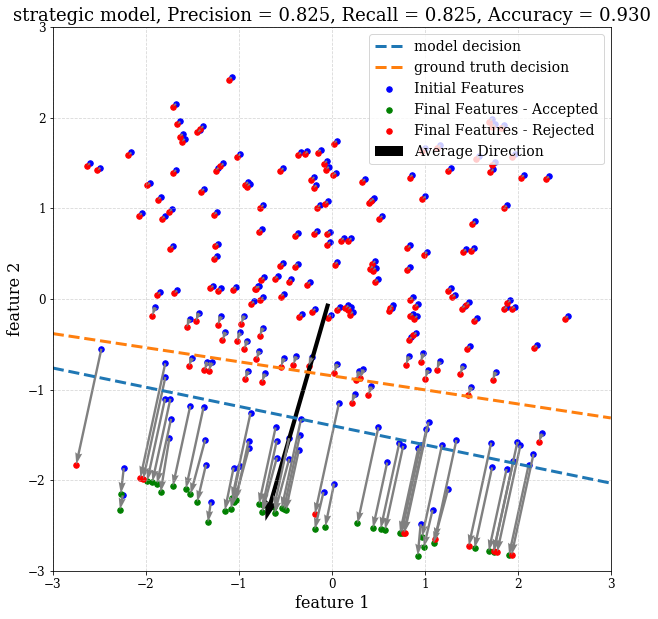

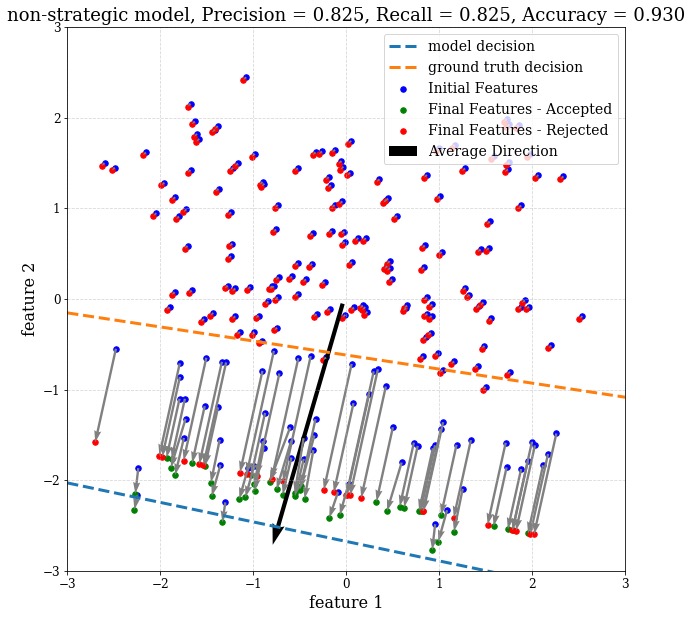

In [38]:
# plot results
print(f'ground truth - preference vector, u = {rank_env.system_attributes}')
print(f'strategic model, w = {rank_env.w}, b = {rank_env.b}')
our_scatter(rank_env, model_strategic, X_test, strategic_test_metrics, title='strategic model', use_lin_search=True, lin_search_sample_num=20)
print(f"strategic model burden = {strategic_test_metrics[strategic_test_metrics['epoch num'] == 9]['burden'].values}")
print(f'non-strategic model, w = {rank_env_non_strategic.w}, b = {rank_env_non_strategic.b}')
our_scatter(rank_env_non_strategic, model_non_strategic, X_test, non_strategic_test_metrics, title='non-strategic model', use_lin_search=True, lin_search_sample_num=20)
print(f"non-strategic model burden = {non_strategic_test_metrics[non_strategic_test_metrics['epoch num'] == 9]['burden'].values}")

#### Figure Explanation 
~TODO: Done~

The figure consists of dots representing features, their place according to their feature values.

The blue dots reresent the initial value of the features, i.e. before the strategic users changed them, the green dots are the updated feature values of users which were supposed to get accepted according to the ground truth, and the red dots are the updated feature values of users which were not supposed to get accepted according to the ground truth.

Also, the figure has 2 lines, representing the model's decision boundry: The orange line represents the ideal, ground truth decision boundry, while the blue one is the decision boundry of the model campe up with.

We also added arrows to show at which direction each user updated his feature values, and the overall direction represented with the black big arrow.

#### Conclusions
We see that the precision, recall and accuracy results are overall the same. For some runs even the non-strategic model gives better results. We believe this happens because the ranking system itself provides some sort of natural defence mechanism against strategic behavior. This is done without specifically encoding this is the model. Because if everyone competes and improves the rating, then the acceptance threshold moves accordingly. This helps the model to still accept the best competitors. 

It is important to note that this model is not fully non-strategic as it actually learns on strategic data. 
In the training process the model simulates the feature update and trained on updated features based on the approximated model used by the strategic model, it is just not included in the derivatives. This means the model doesn't experience strong out-of-distribution (OOD) effects it just isn't explicitly aware of the feature update model.
 
The strategic model sometimes preforms poorly because the optimization is harder in this case. And we approximate and neglect some of the 

We do see that the strategic model chooses a $w$ with a smaller magnitude (length). This causes the change in user features to impact the model rating less since $r_{\theta}(x) = w^Tx+b$. 
TODO: finish explaining the difference in magnitude.

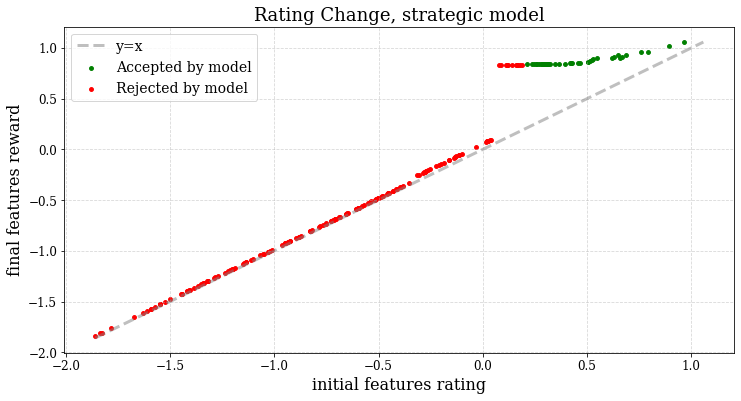

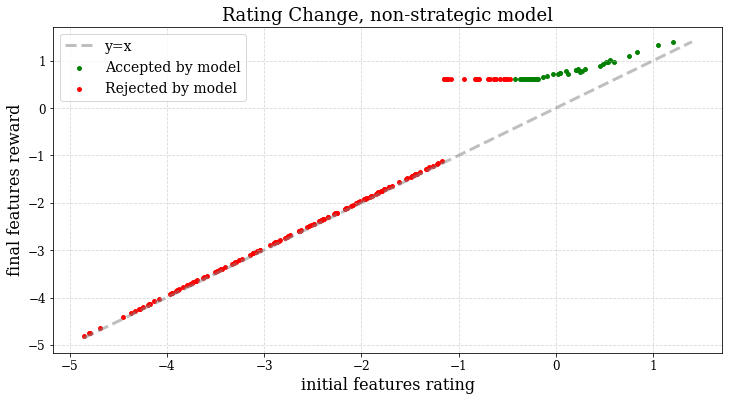

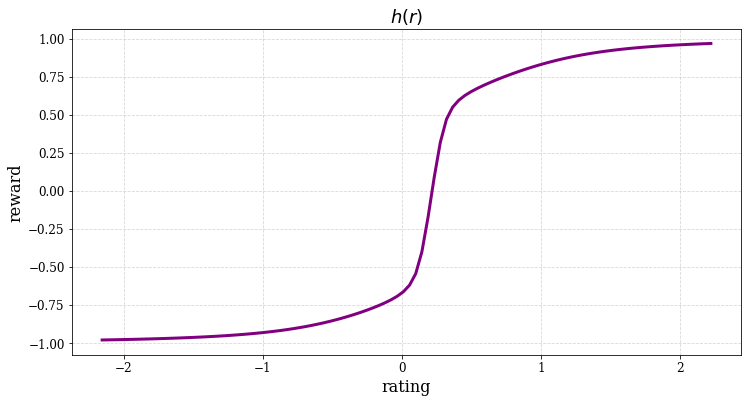

In [39]:
# plotting for the test batch
plot_rating_change(rank_env, model_strategic, X_test, title=f'strategic model')
plot_rating_change(rank_env_non_strategic, model_non_strategic, X_test, title=f'non-strategic model')
view_reward_func(rank_env, R_test, X_test)

TODO: explain what we see in the figures and discuss.
We can see that the results are very similar.

This is an interesting result (if it is true), it may mean that ranking is less sensitive to strategic behavior. This makes some sense as if everyone increases their rating at the same rate then just accepting the top-$k$ will move the threshold. This is the behavior that we have seen in classic strategic classification. It does not explain why the user barely change their features. 

We should try regularizing for burden or maybe a more complex rating model, such as quadratic.

#### 3.1.2 With burden regularization - maybe remove this

In this experiment we added a regularization according to the burden in order to see its effects on the results.

In [40]:
lin_search_sample_num = 20
burden_reg = 0.1
model_non_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env_non_strategic, strategic=False, lin_search_sample_num=lin_search_sample_num, burden_reg=burden_reg)
model_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True, lin_search_sample_num=lin_search_sample_num, burden_reg=burden_reg)

path_strategic = f"./tests/2d_test_uniform/strategic_burden"
path_non_strategic = f"./tests/2d_test_uniform/non_strategic_burden"
epochs = 10
batch_size = env_params['n_users']
total = []
ccp = []

# for non-strategic with strategic data - use_delta must be set to false, else set it to true
non_strategic_train_metrics, non_strategic_test_metrics = model_non_strategic.fit(path_non_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=False, verbose=VERBOSE,
                comment="batched")

strategic_train_metrics, strategic_test_metrics = model_strategic.fit(path_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=True, verbose=VERBOSE,
                comment="batched")


# convert to pd DataFrame
strategic_train_metrics = pd.DataFrame(strategic_train_metrics)
strategic_test_metrics = pd.DataFrame(strategic_test_metrics)
non_strategic_train_metrics = pd.DataFrame(non_strategic_train_metrics)
non_strategic_test_metrics = pd.DataFrame(non_strategic_test_metrics)

model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 132.30278062820435 seconds
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 248.0063271522522 seconds


strategic model, w = Parameter containing:
tensor([-0.0945, -0.5990], requires_grad=True), b = Parameter containing:
tensor([-0.5172], requires_grad=True)
strategic model burden = 0     0.668068001143084
1    0.6527886800298831
2    0.6285011527906323
3    0.6040547943126671
4    0.5989517358115128
5    0.6596645692514972
6    0.6106213292079754
7    0.6612782452537967
8    0.6321358756385055
9    0.6123487136382371
Name: burden, dtype: object
non-strategic model, w = Parameter containing:
tensor([-0.2601, -1.2077], requires_grad=True), b = Parameter containing:
tensor([-2.0046], requires_grad=True)
non-strategic model burden = 0     0.5558254055684435
1     0.6387138745160257
2     0.5797155357128672
3      0.482441291506747
4    0.46764442444451093
5     0.4632523154496254
6     0.4534004438892906
7      0.418754867106531
8    0.44425957365387836
9    0.45961389534689756
Name: burden, dtype: object


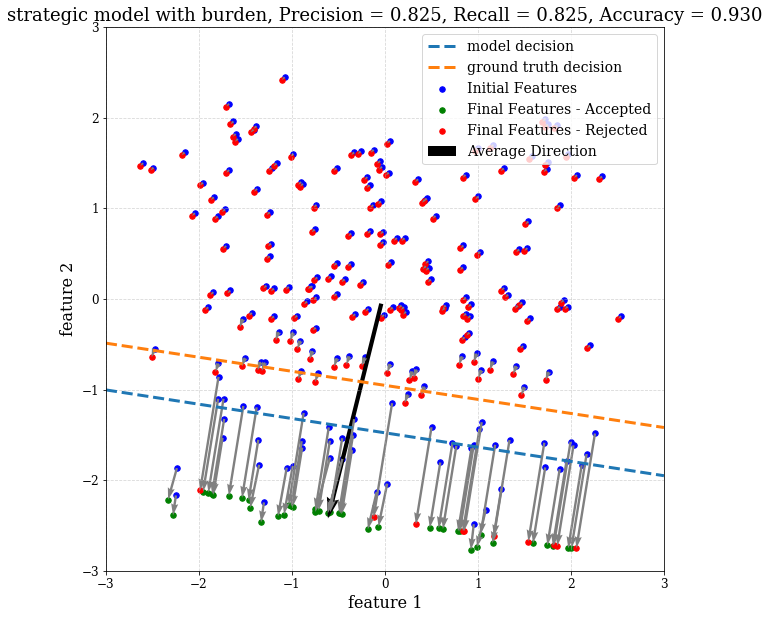

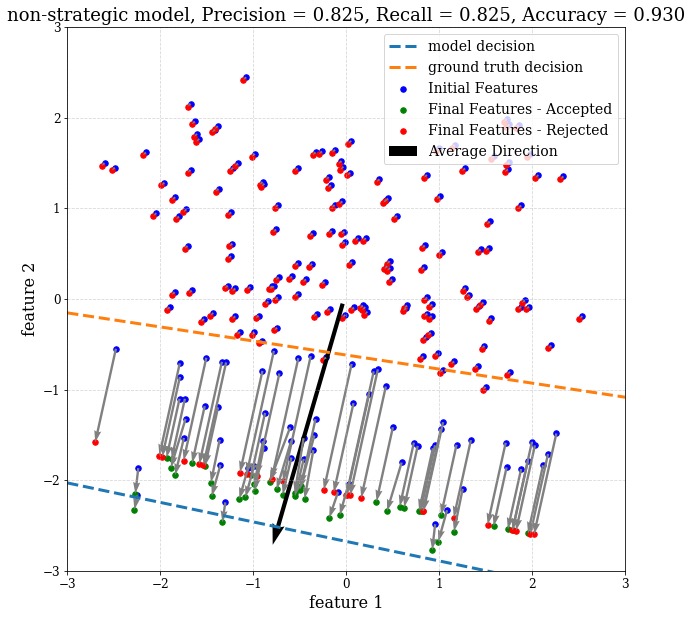

In [41]:
# plotting for the test batch
print(f'strategic model, w = {rank_env.w}, b = {rank_env.b}')
our_scatter(rank_env, model_strategic, X_test, strategic_test_metrics, title='strategic model with burden', use_lin_search=True, lin_search_sample_num=20)
# our_scatter(rank_env, model_strategic, X_test, strategic_test_metrics, title='strategic model with burden, forward features', use_lin_search=True, lin_search_sample_num=20, use_features_from_model=True)
print(f"strategic model burden = {strategic_test_metrics['burden']}")
print(f'non-strategic model, w = {rank_env_non_strategic.w}, b = {rank_env_non_strategic.b}')
our_scatter(rank_env_non_strategic, model_non_strategic, X_test, non_strategic_test_metrics, title='non-strategic model', use_lin_search=True, lin_search_sample_num=20)
print(f"non-strategic model burden = {non_strategic_test_metrics['burden']}")
# our_scatter(rank_env_non_strategic, model_non_strategic, X_test, non_strategic_test_metrics, title='non-strategic model, forward features', use_lin_search=True, lin_search_sample_num=20, use_features_from_model=True)

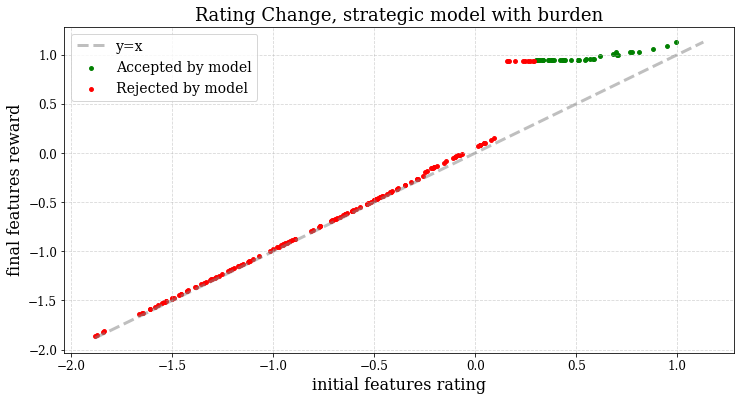

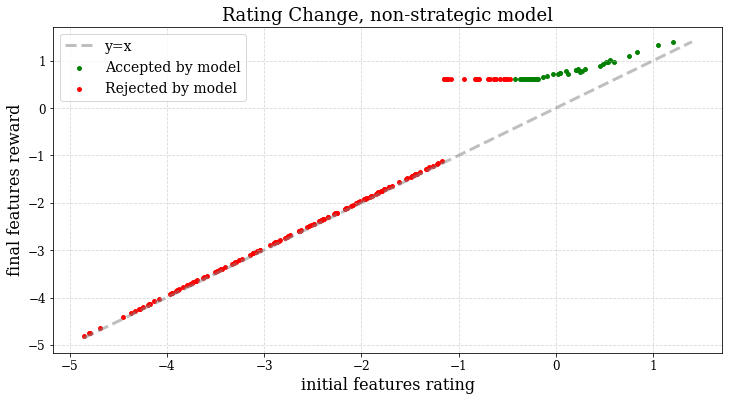

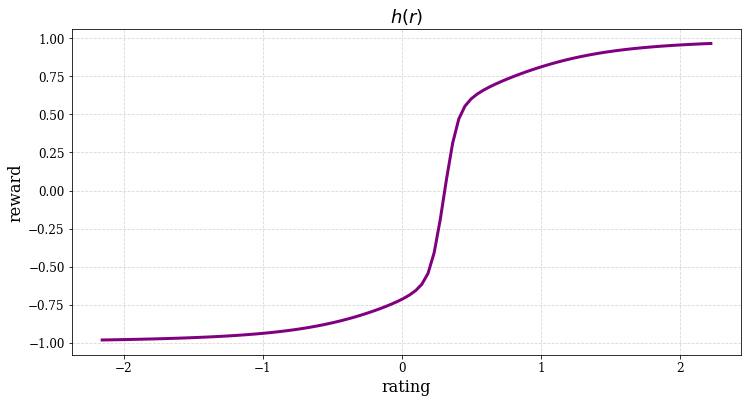

In [42]:
# plotting for the test batch
plot_rating_change(rank_env, model_strategic, X_test, title=f'strategic model with burden')
plot_rating_change(rank_env_non_strategic, model_non_strategic, X_test, title=f'non-strategic model')
view_reward_func(rank_env, R_test, X_test)

### 3.2 Different contest parameters

Next, we perfomed changes to the contest parameters in order to see how they influence the model, and explore different trends.

#### 3.2.1 Slopes experiments
#### 3.2.1.1 with strategic model

In those experiment we want to test the model's performance for different slopes.

now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 265.4491424560547 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 240.53971457481384 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 179.0428454875946 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 172.49527215957642 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 168.4459147453308 seconds


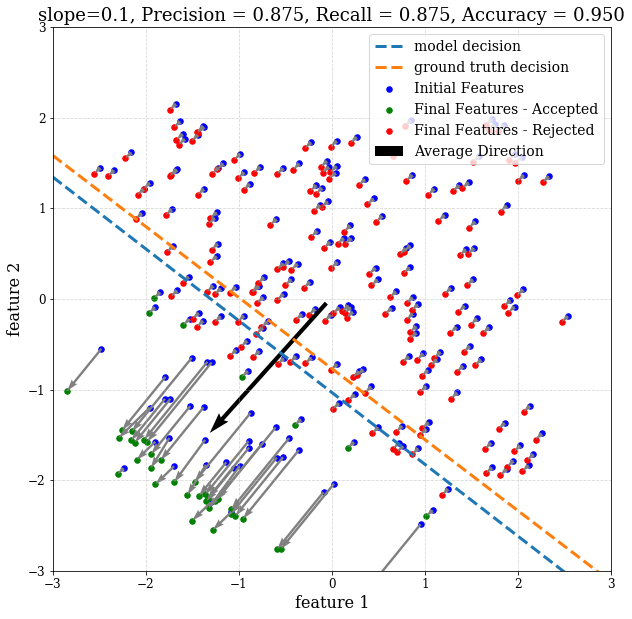

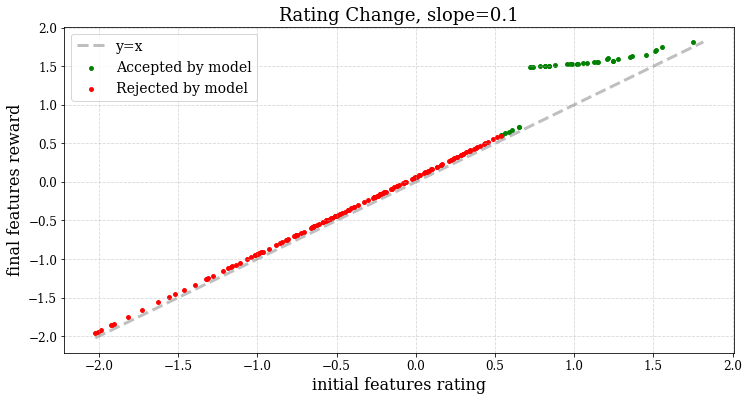

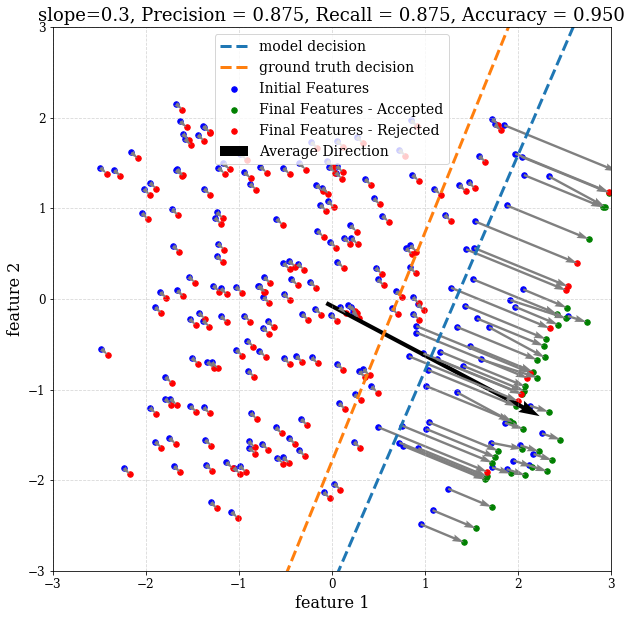

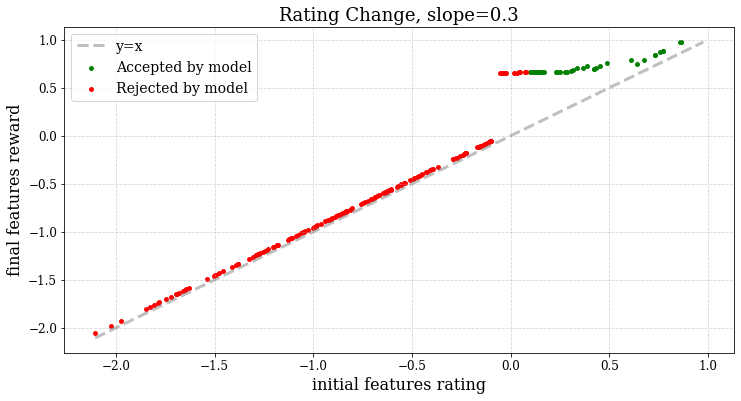

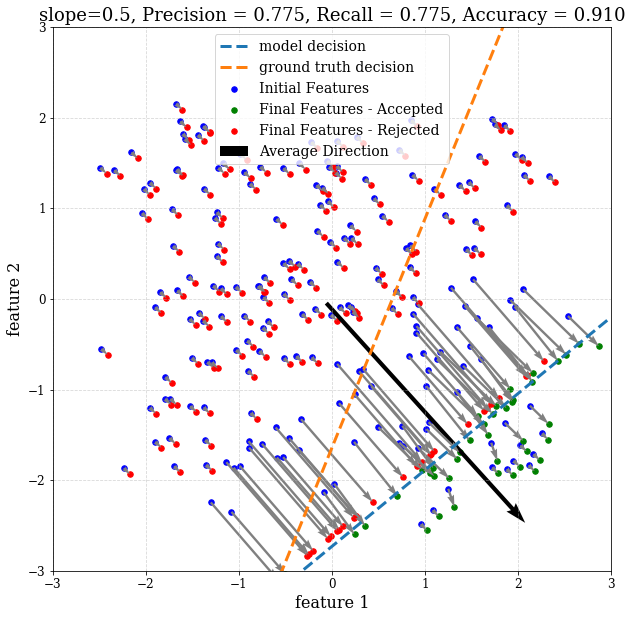

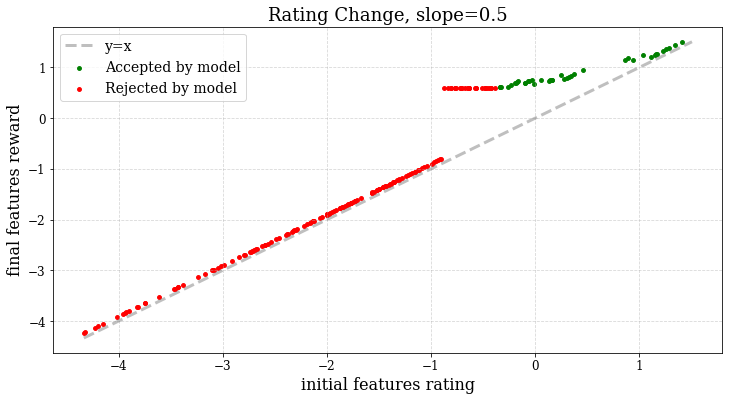

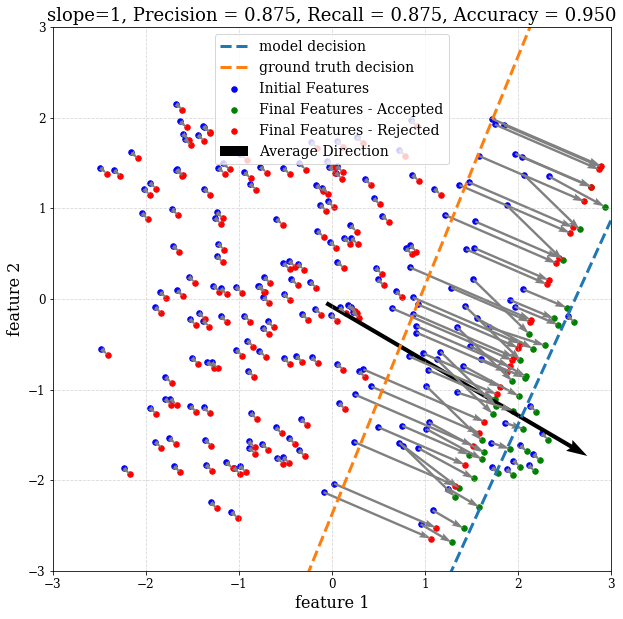

In [43]:
# defining different environments for different slopes
slope_vals = [0.1, 0.3, 0.5, 0.7, 1]
scale = 1

for slope_val in slope_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_slope_test_{slope_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'slope={slope_val}')
    plot_rating_change(rank_env, model, X_test, title=f'slope={slope_val}')
        

#### Probably remove this later - non very informative 

In [44]:
# seeing for which slopes we achieved better results
# defining differen environments for different slopes
slope_vals = [0.1, 0.3, 0.5, 1, 2]
train_metrics = pd.DataFrame([])
test_metrics = pd.DataFrame([])

for slope_val in slope_vals:
    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_slope_test_{slope_str}/strategic"

    # reading metrics
    train_metric = pd.read_csv(path_strategic + '/train_metrics.csv')
    train_metric["slope_val"] = slope_val
    train_metrics = pd.concat([train_metrics, train_metric])

    test_metric = pd.read_csv(path_strategic + '/test_metrics.csv')
    test_metric["slope_val"] = slope_val
    test_metrics = pd.concat([test_metrics, test_metric])


# plotting
(
    test_metrics[test_metrics['epoch num'] == 9]
    .pivot(
        index='precision',
        columns='slope_val',
        values='burden',
    )
    .plot.line(
        title='precision over different slope vals',
        xlabel='Precision',
        ylabel='Burden',
        figsize=(12,6),
        marker='o'
    )
)
plt.show()

We can see that as the slope value increases, the precision, accuracy and recall of the models decreases, while the burden increases.

It can be explained because # TODO

#### 3.2.1.2 with non-strategic model

now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 155.90280413627625 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 124.15318441390991 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 95.94973278045654 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 84.32241201400757 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 74.4524176120758 seconds


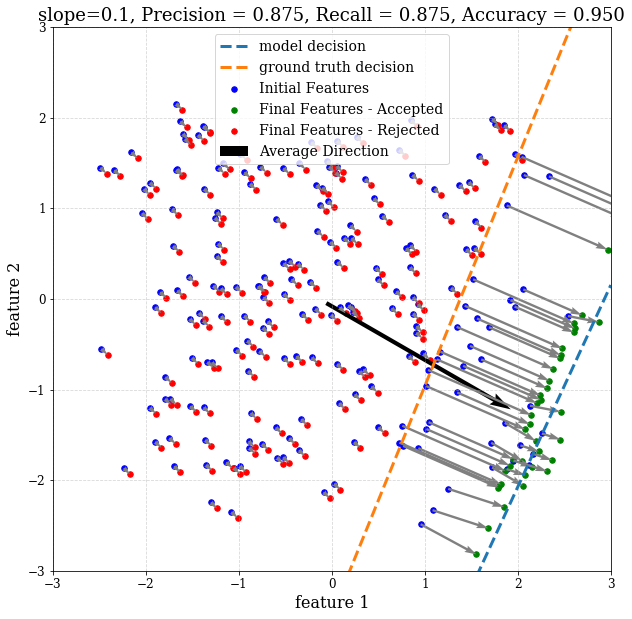

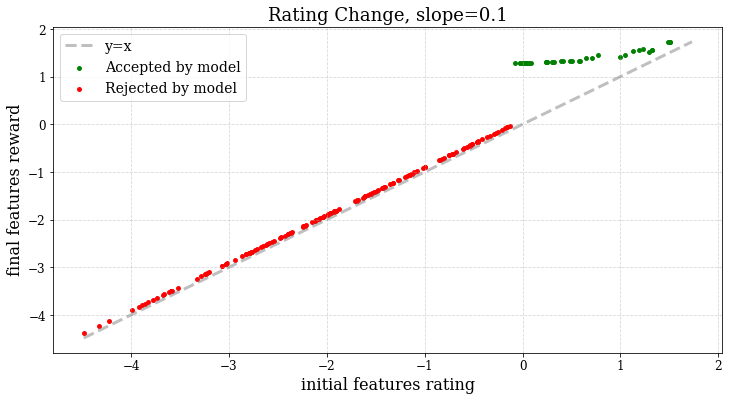

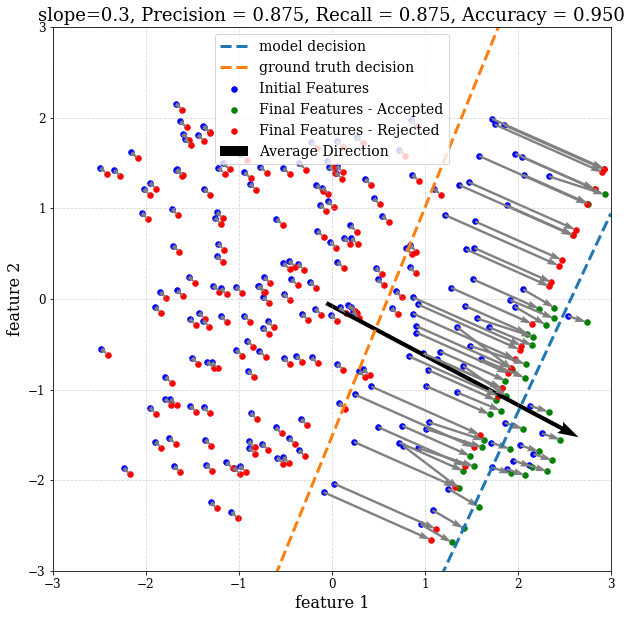

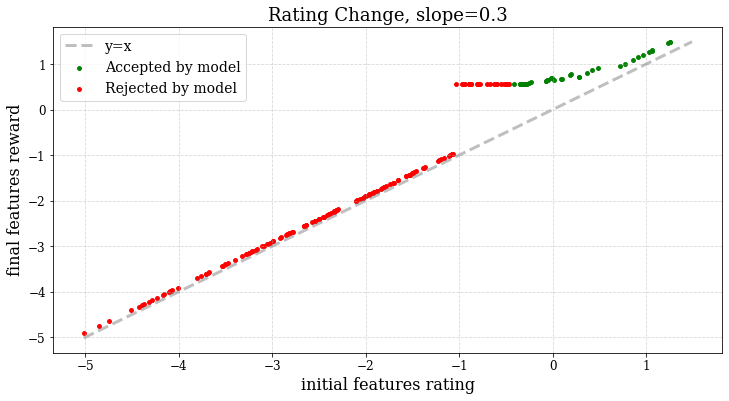

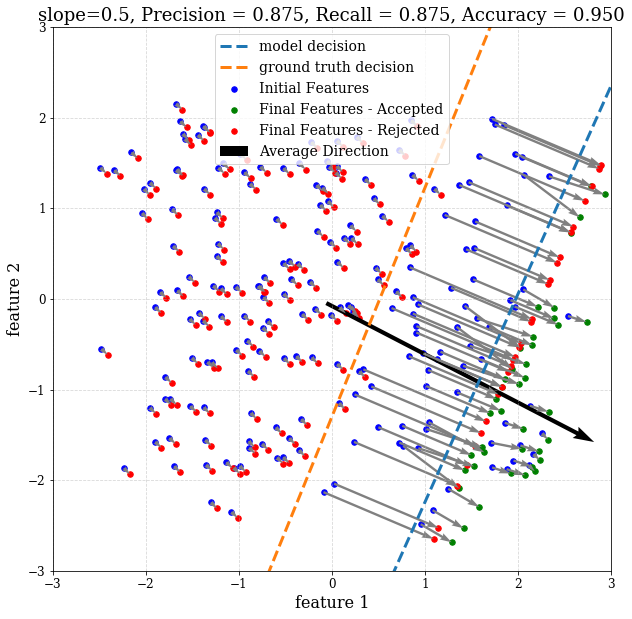

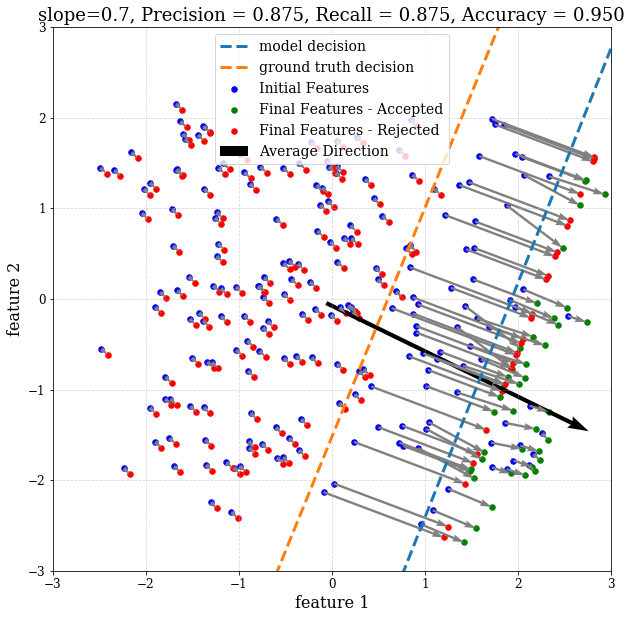

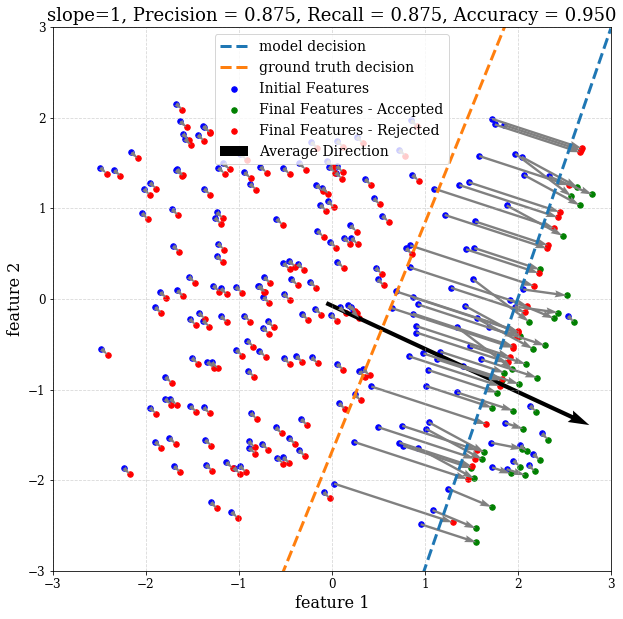

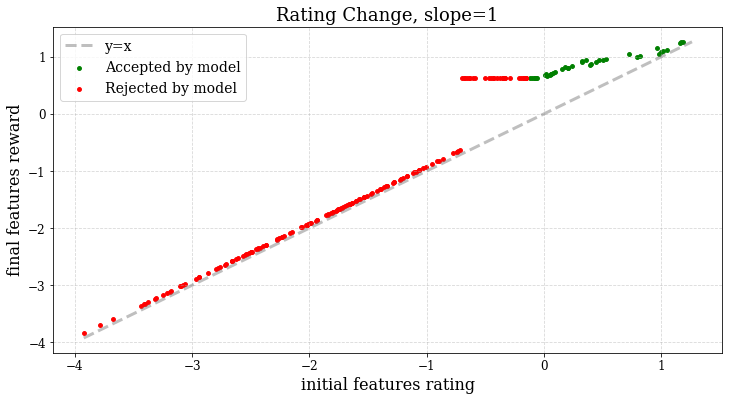

In [45]:
# defining different environments for different slopes
slope_vals = [0.1, 0.3, 0.5, 0.7, 1]
scale = 1

for slope_val in slope_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    # this time we are working with a non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_slope_test_{slope_str}/non_strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'slope={slope_val}')
    plot_rating_change(rank_env, model, X_test, title=f'slope={slope_val}')
        

#### Conclusion
As the slope increases more and more users choose to approach the threshold and cross it as it becomes more rewarding. Users far from the threshold are not affected, this is because the low slope is high (the step is steep and very local). Hence, near movements don't affect the reward much (the reward is almost zero there). 

#### 3.2.2 Scales experiment

 Next, we wanted to check the effects of scales on the results of the model.
 
 The scale affects the price of changing the features according to distance moved:
 
 $$c(x,x_t)=\text{scale}\cdot\lVert x-x_t \rVert ^2$$
 
 **Note:** We've seen so far that the non-strategic model had the same or (in few cases) better results than the strategic one.
 
 Therefore from this experiment we will by default run on the non-strategic model (unless we want to compare it to the strategic model).

now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 78.04813742637634 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 115.83338165283203 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 123.01387763023376 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 115.74814319610596 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 103.33255958557129 seconds


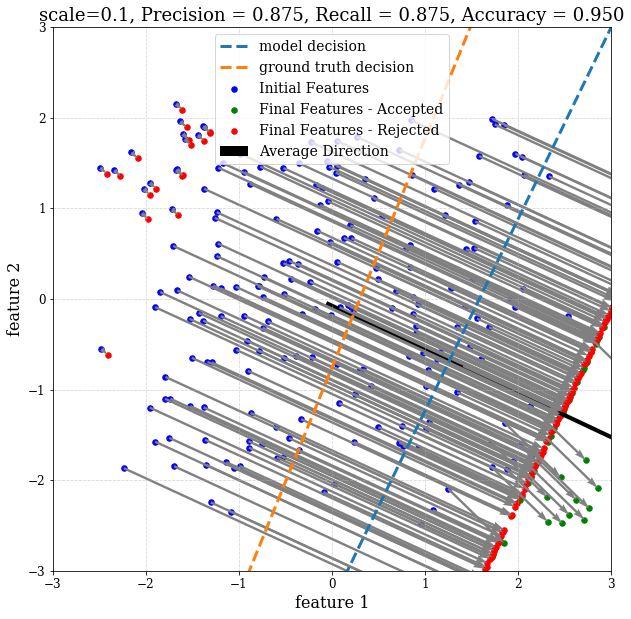

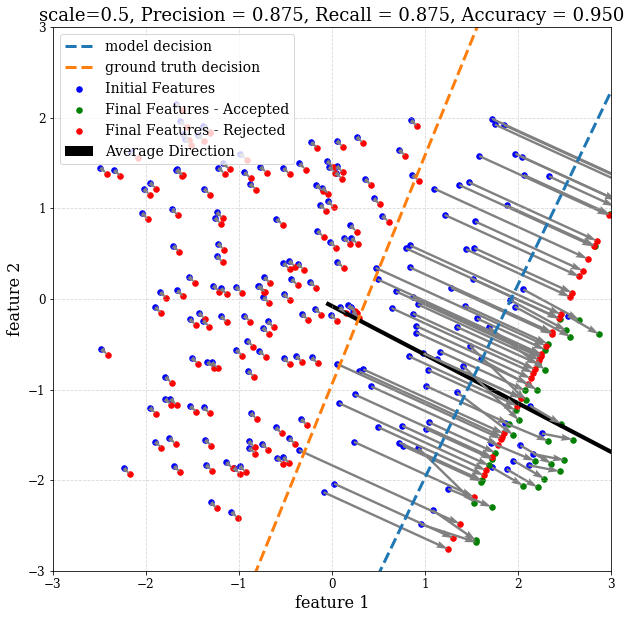

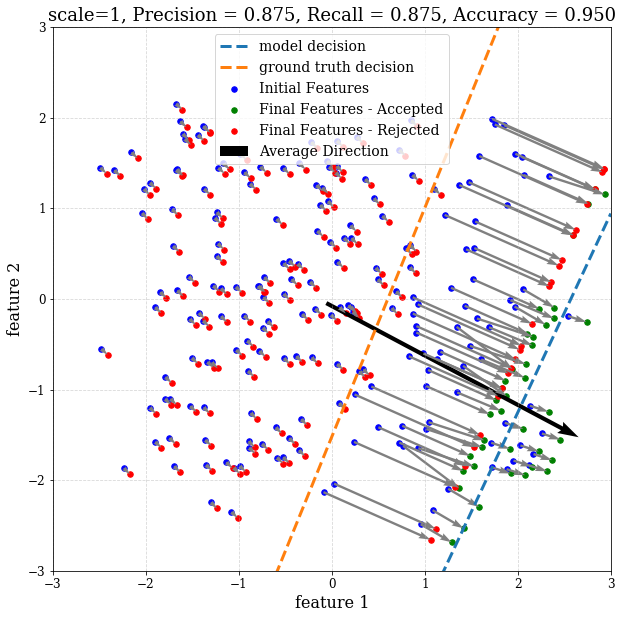

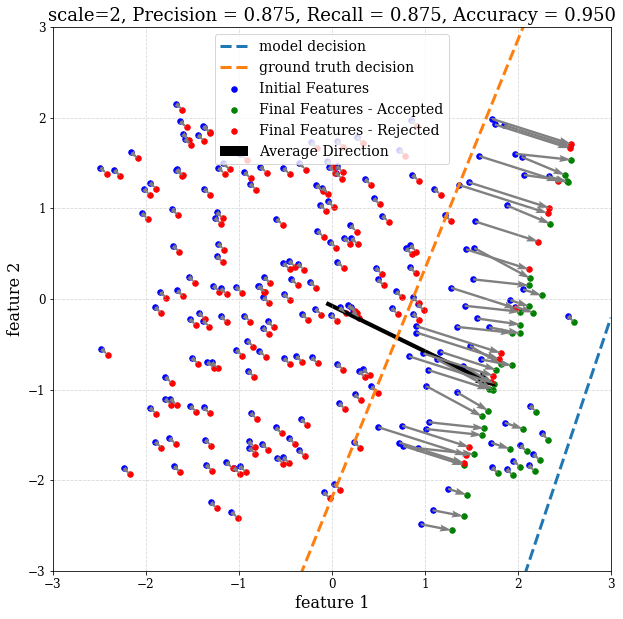

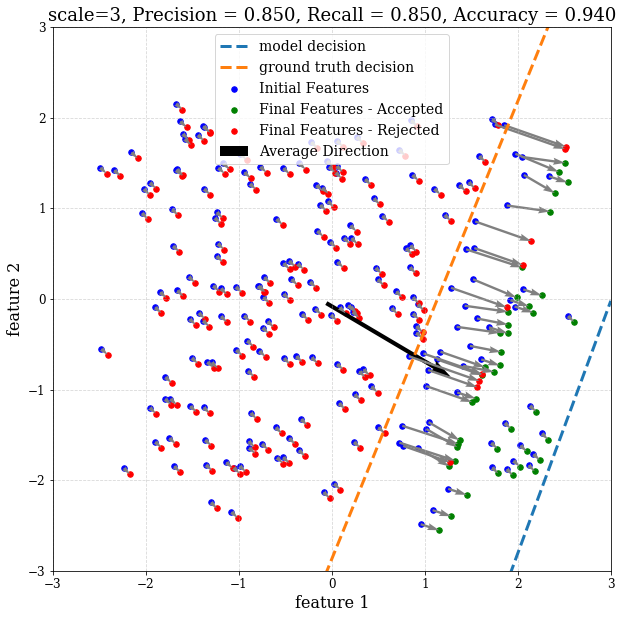

In [46]:
# defining different environments for different slopes
slope_val = 0.3
scale_vals = [0.1, 0.5, 1, 2, 3]

for scale in scale_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    scale_str = str(scale).replace('.', ',')
    path_strategic = f"./tests/2d_scale_test_{scale_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'scale={scale}')
        

#### Conclusion
As expected the users move more as the scale decreases (less cost for movement). 
TODO: elaborate, if possible connect to the predictive performance (accuracy etc.)

#### 3.2.3 K experiment 
**Note**: We fixed $k'=\text{round}(k/2)$.

now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 146.02611684799194 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 139.71198916435242 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 130.4733591079712 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 122.75988578796387 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 115.59667253494263 seconds


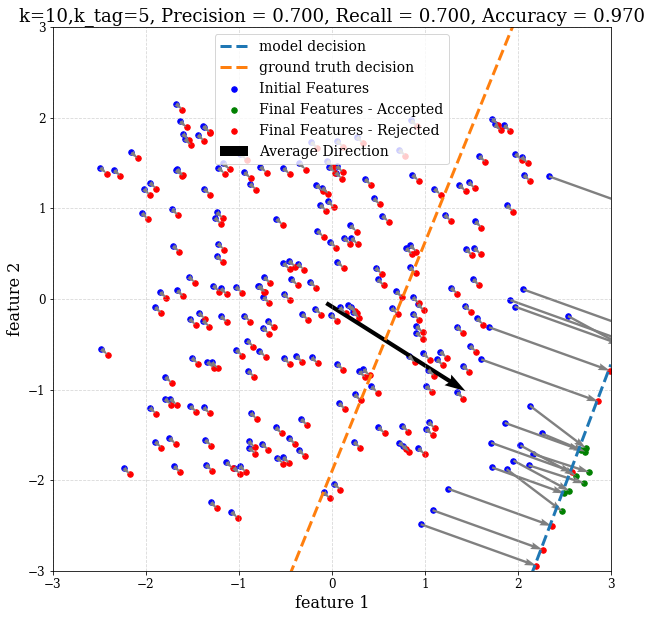

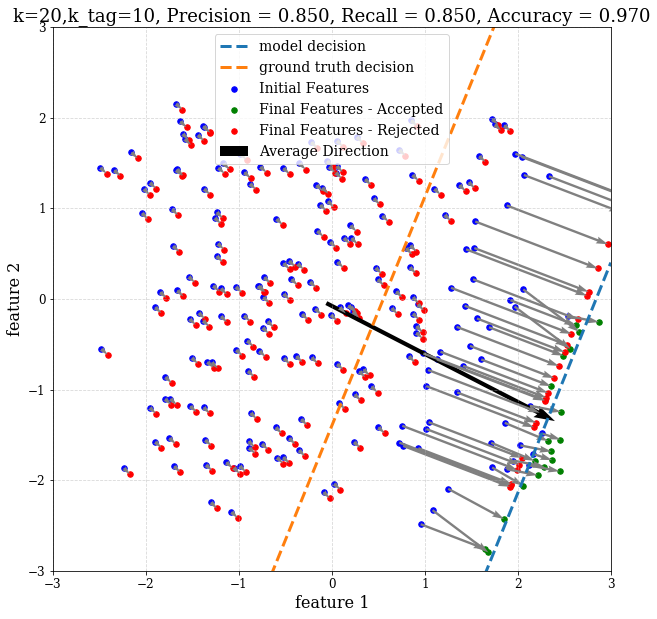

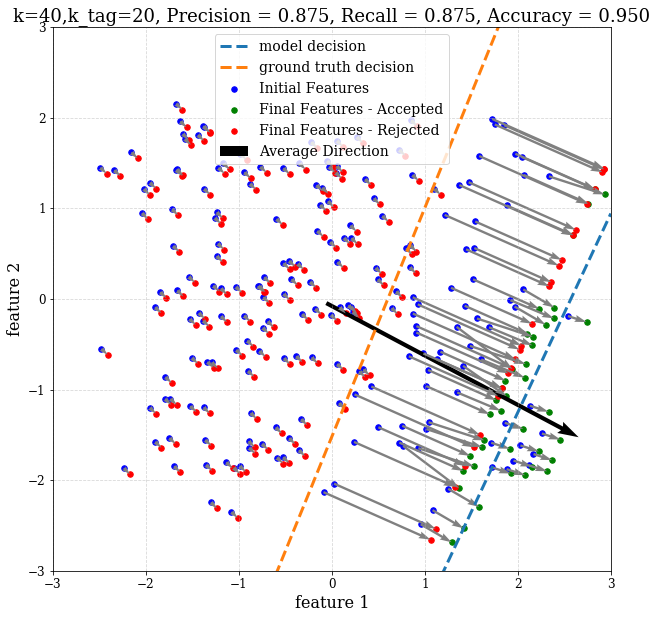

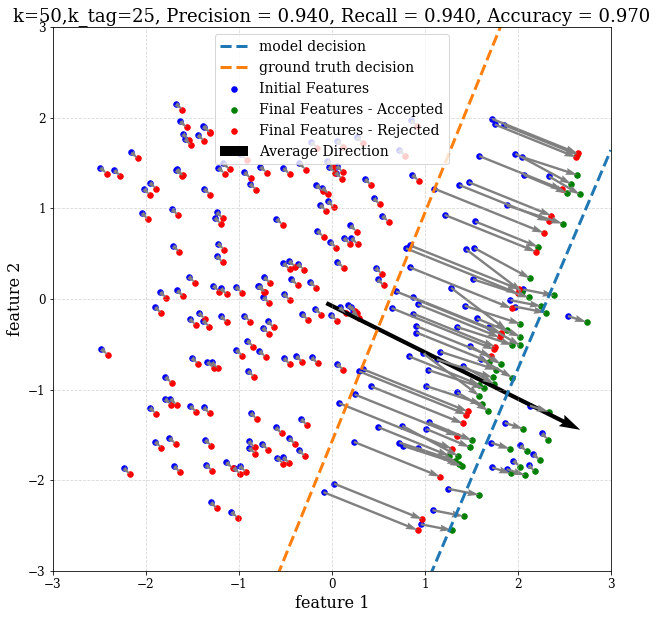

In [47]:
# defining different environments for different slopes
slope_val = 0.3
scale = 1
k_vals = [10, 20, 30, 40, 50]

for k in k_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : k,
                'k_tag' : k // 2,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : scale,
                'n_batch' : 5}
    
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var()
    rank_env.set_scale(scale / (feature_var))

    k_str = str(k).replace('.', ',')
    path_strategic = f"./tests/2d_test_k_{k_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'k={k},k_tag={k // 2}')
        

#### Conclusion 
We see overall that as k increases the predictive performance is better. 
TODO: explain why, easier to trick the system.

#### 3.2.4 k' experiment

now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 123.02830958366394 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 122.82821273803711 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 124.408358335495 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 124.14098906517029 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 121.8293685913086 seconds


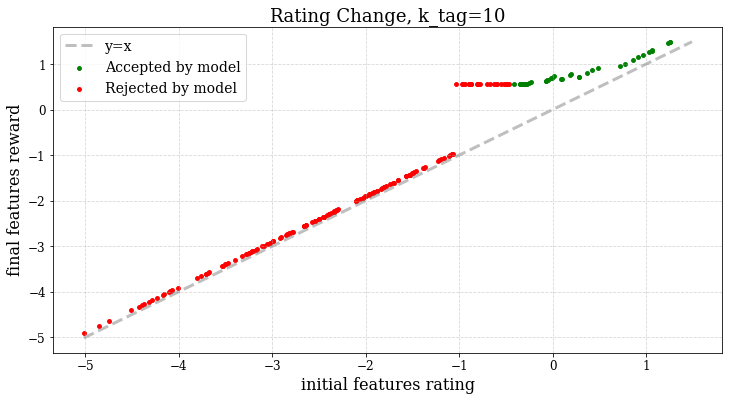

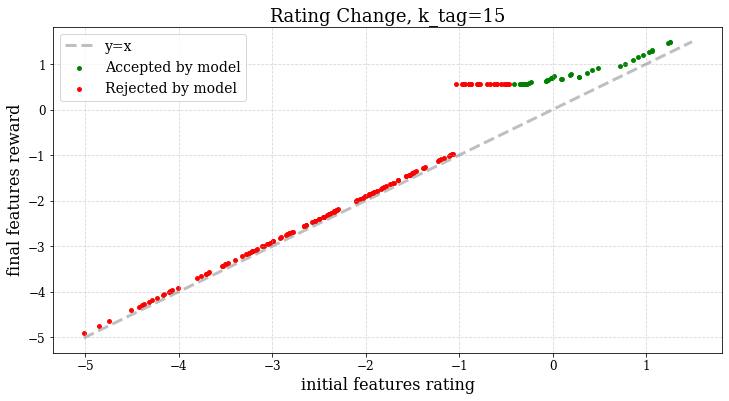

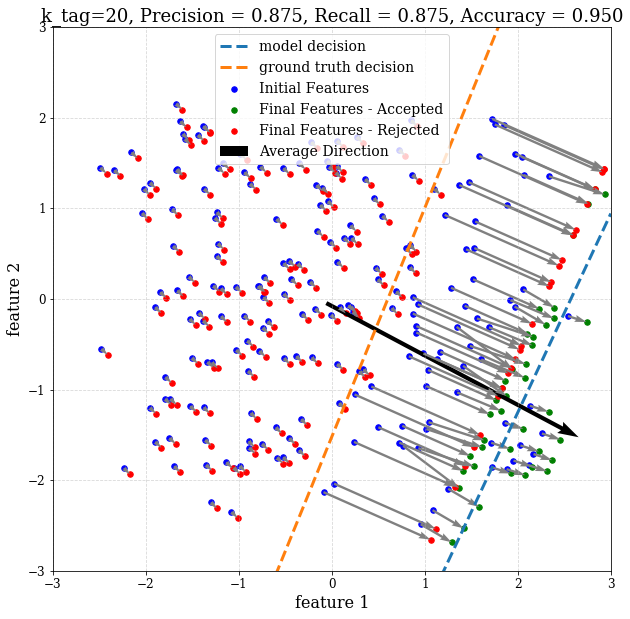

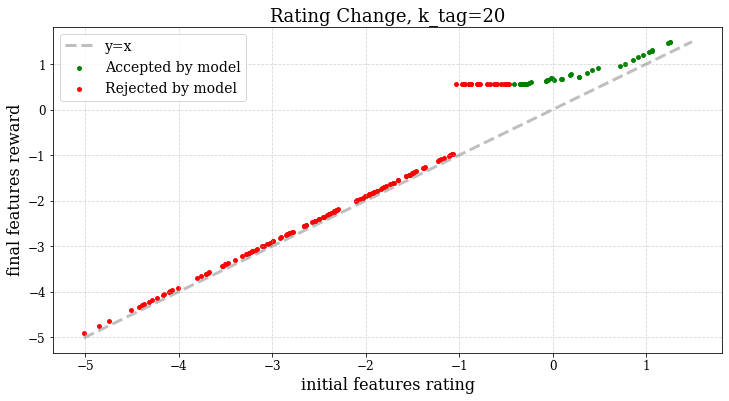

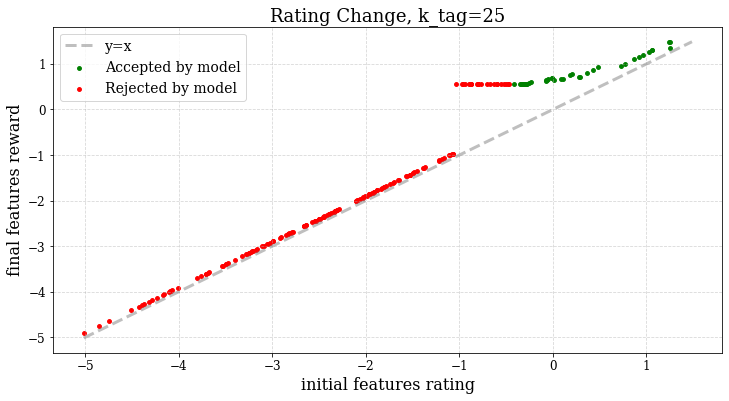

In [48]:
# defining different environments for different slopes
k_tag_vals = [5, 10, 15, 20, 25]
slope_val = 0.3
scale = 1

for k_tag in k_tag_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : k_tag,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_test_k_tag_{k_tag}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'k_tag={k_tag}')
    plot_rating_change(rank_env, model, X_test, title=f'k_tag={k_tag}')
        

#### Conclusion
Doesn't seem to affect the results very much.
TODO: elaborate

#### 3.2.5 Acceptance reward experiment


now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 123.60783052444458 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 128.33020782470703 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 124.48184013366699 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 120.97174906730652 seconds


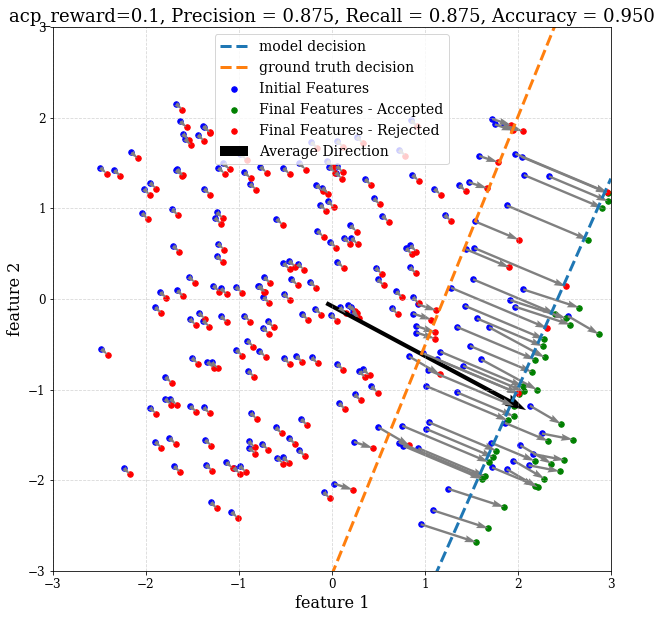

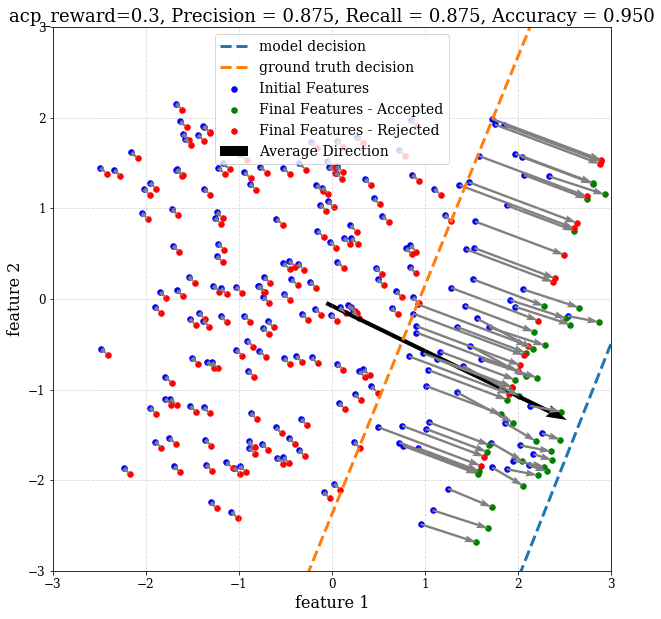

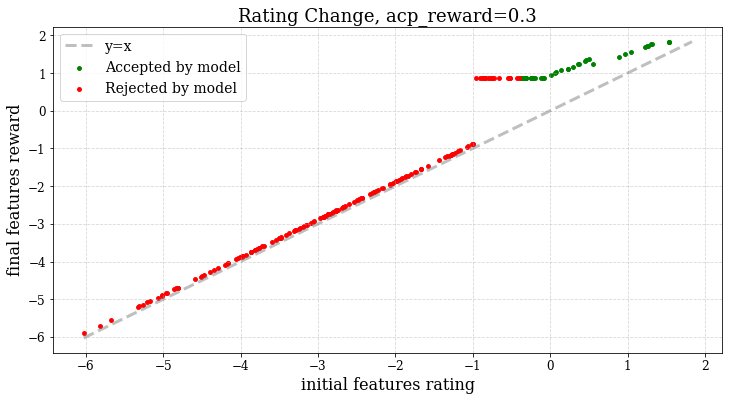

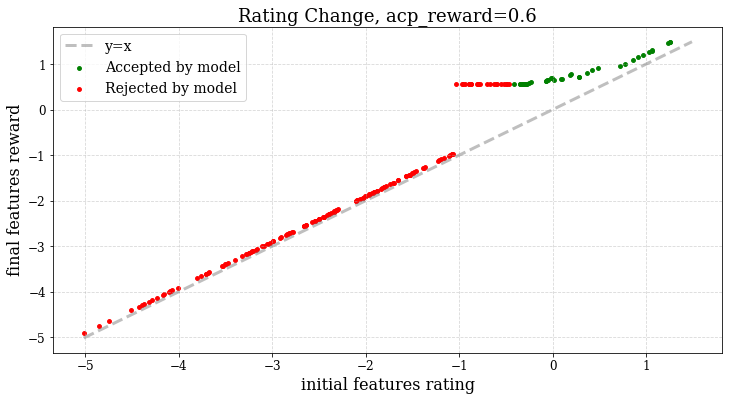

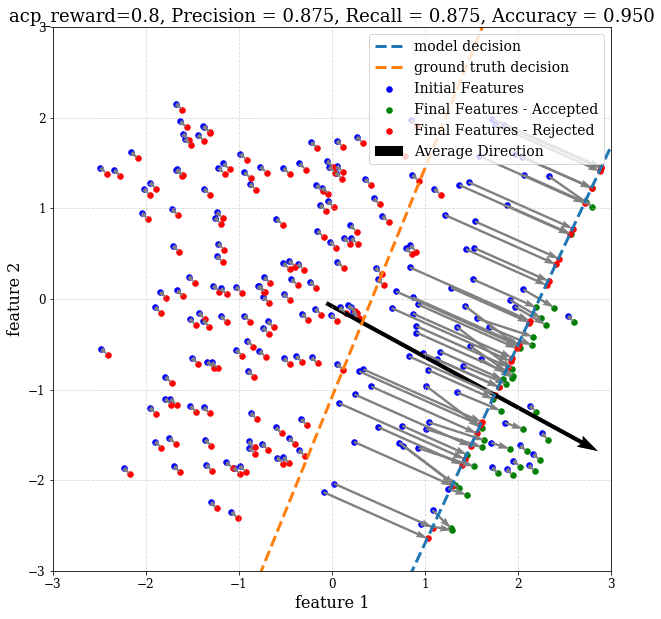

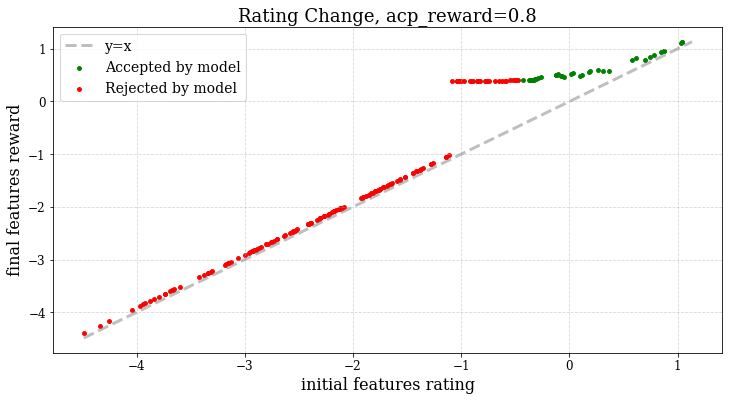

In [49]:
# defining different environments for different slopes
acp_reward_vals = [0.1, 0.3, 0.6, 0.8]
slope_val = 0.3
scale = 1

for acp_reward in acp_reward_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : acp_reward,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    acp_str = str(acp_reward).replace('.', ',')
    path_strategic = f"./tests/2d_test_acp_{acp_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'acp_reward={acp_reward}')
    plot_rating_change(rank_env, model, X_test, title=f'acp_reward={acp_reward}')
        

#### Conclusion
We can see that as the acceptance reward increases, more and more users which weren't supposed to get accepted got past the threshhold.
It makes sense, since as the acceptance reward increases, there is more weight on the lower slope and therefore it grows steeper, and more users succeed in getting past it.

We see that those who can get past the threshhold do so, but those who can't in most cases don't change their features a lot. It only happens when the acceptance rate is the lowest (0.1) that even though they don't pass the threshhold, some users try to get past it (we see that there are couple of red dots which are not at the threshhold level but they have improved their features).

A connected effect is that as the accepted reward decreases, the users which already got accepted improve their features even more (even though they got accepted), a thing which can be seen by the growing distance of the green dots from the gray line as the acceptance reward decreases.

These effects can be thought of as the acceptance reward shrinks, the cost to get passed the threshhold decreases, so more users try to get passed it (effect 1), and because those who already got accepted see that there are more users who can get passed the threshhold, they keep their spots by increasing their features more (effect 2).
 
~TODO: Done.~

### 3.3 Individual scales

As we've seen, so far our model did pretty well and gave pretty accurate results, but we can notice that making him strategic did not add a lot to its accuracy (a naive model gave similar accuracy).

Therefore, we wanted to challenge the model a bit more: we added the option that each user will have its own scale, and therefore will have different cost to change its features.

It corresponds to real-life scenerios which include different means for different individuals. For example, when getting into a university, those with more money and better resources will have easier time get accepted, as they can fund extra learning and private lessons etc.

Our non-strategic model trains on the average scale, and is tested on the individual scales.

now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 112.72239327430725 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 113.3203957080841 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 114.2065920829773 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 113.79619789123535 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 114.31871891021729 seconds


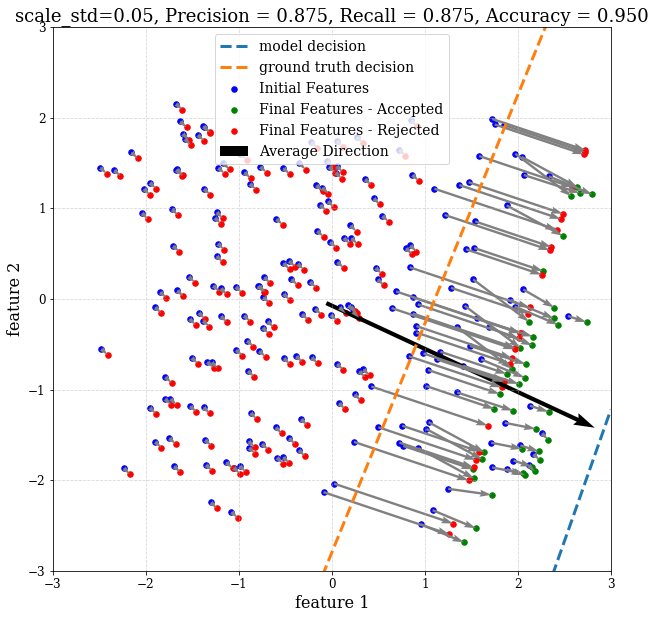

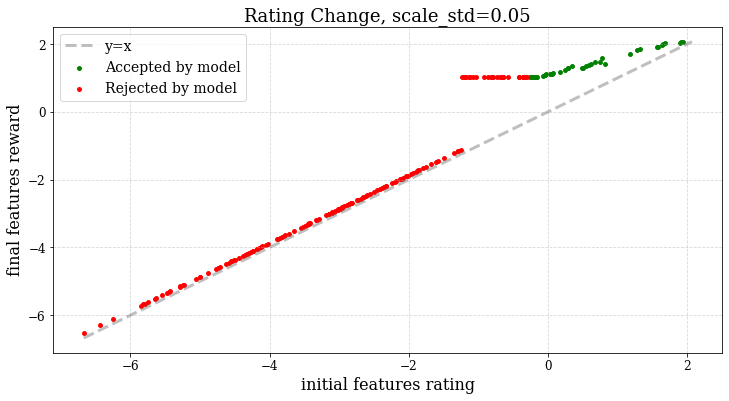

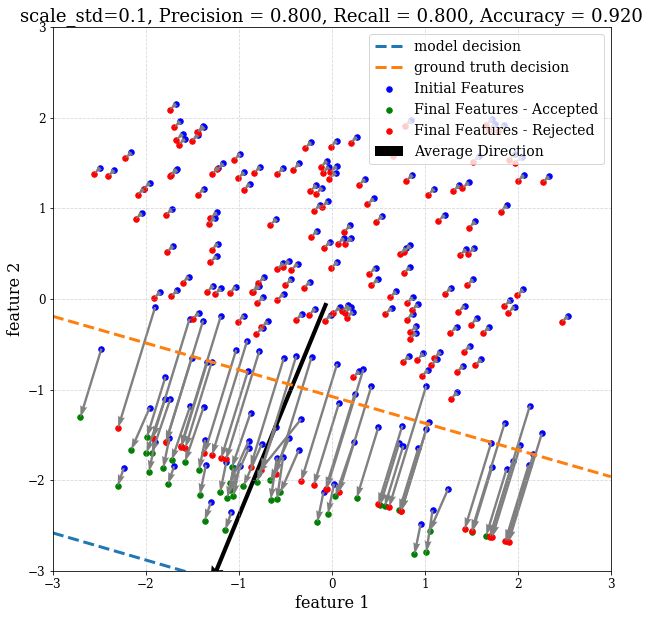

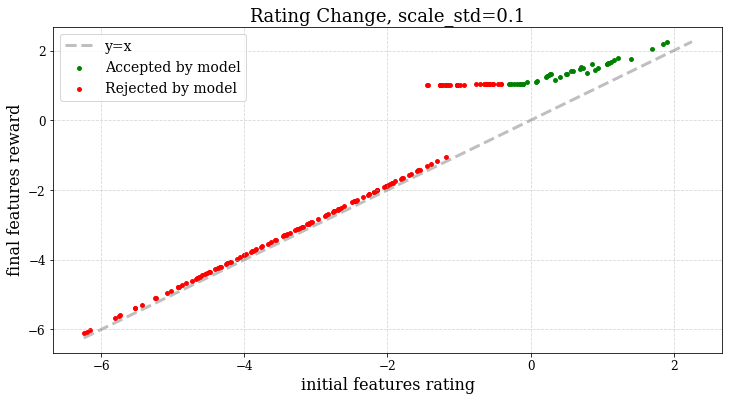

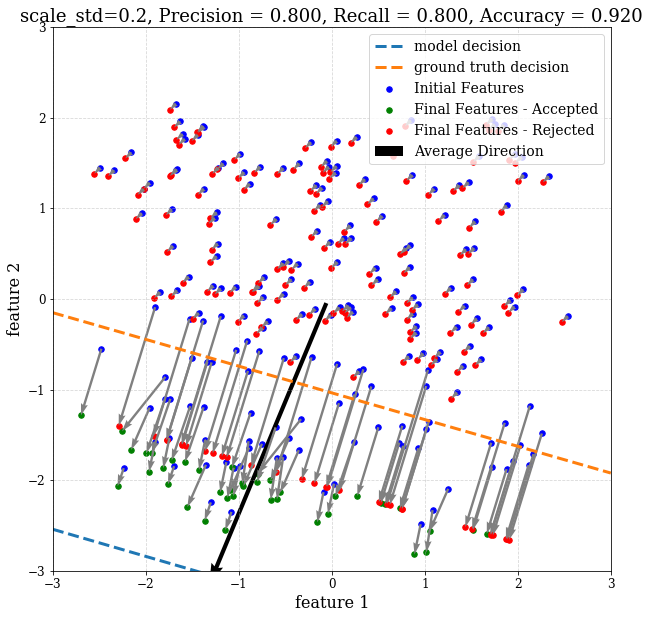

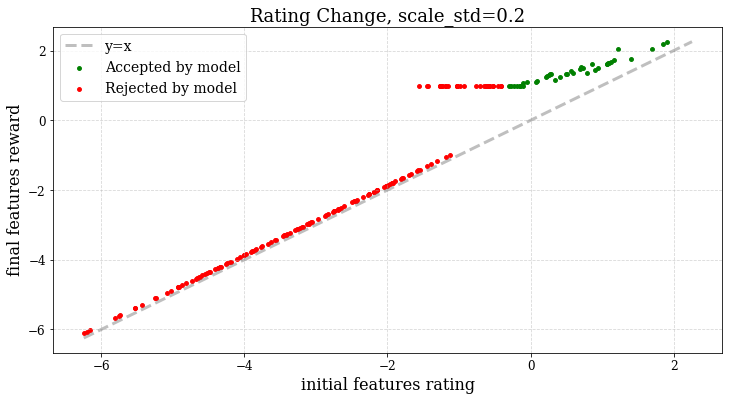

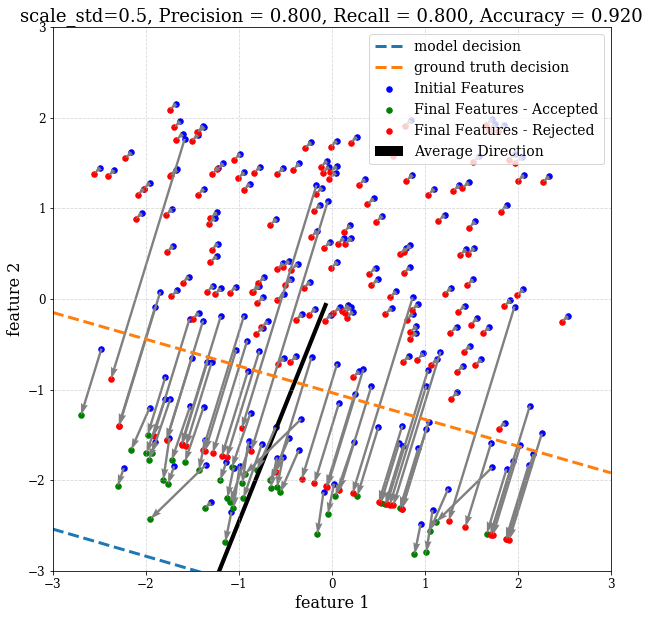

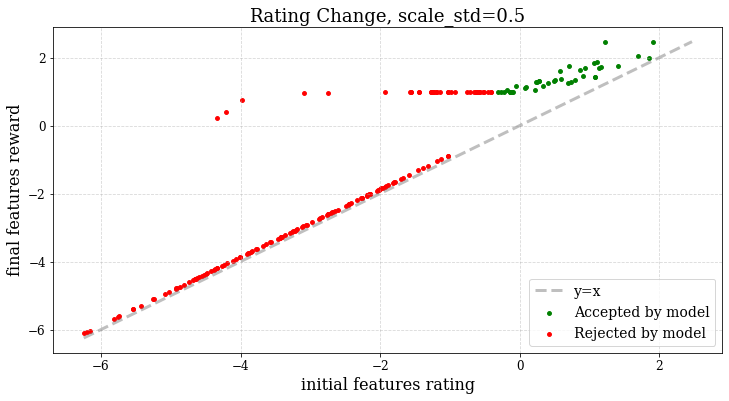

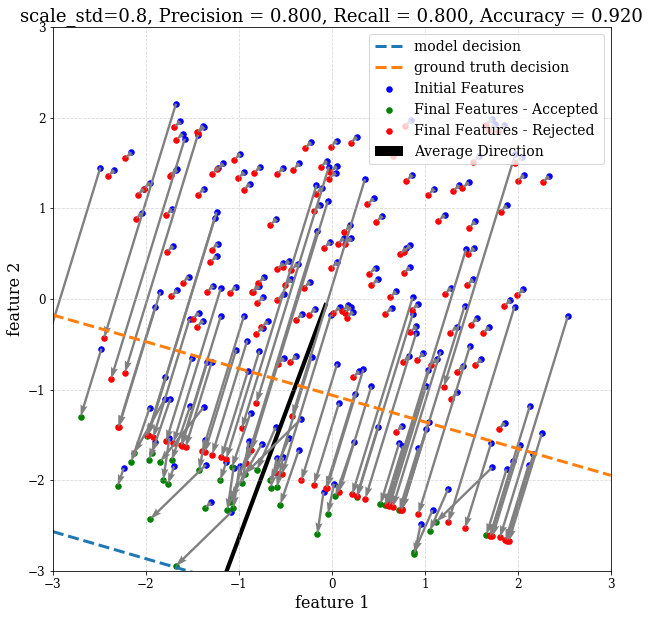

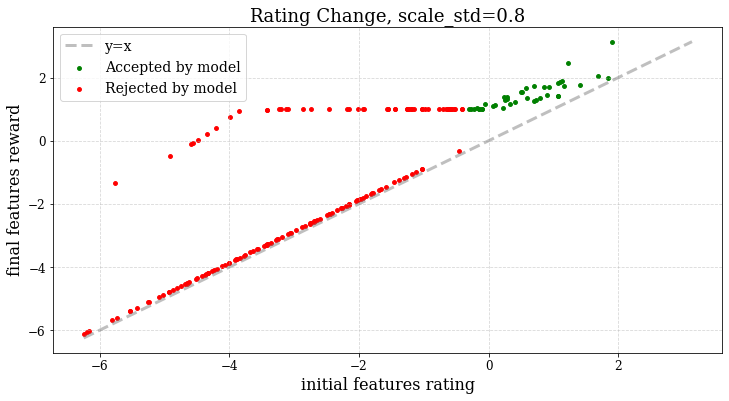

In [50]:
# defining 3 different environments for 3 std's
# defining different environments for different slopes
scale_stds = [0.05, 0.1, 0.2, 0.5, 0.8]
slope_val = 0.3
scale = 2

for scale_std in scale_stds:
    # training with different scale std's
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2,
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : 0.3,
                'slope_high' : 0.3,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch': 5,
                'scale_std': scale_std}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True, indivdual_scale=True)
    X_test, R_test, y_test, scales = rank_env.generate_dataset(is_test=True, uniform_dist=True, indivdual_scale=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))
    scales = scales / feature_var
    
    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/diff_scales_std_test_{scale_std}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched", scales_test=scales)

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'scale_std={scale_std}', scales=scales)
    plot_rating_change(rank_env, model, X_test, title=f'scale_std={scale_std}', scales=scales)
    

### Weight size as a function of scale

In this part we will check a hypothesis we had: that as the scale grows, the trained weights grow as well. This happens because... #TODO

We will compare the results between a strategic and a non-strategic model

now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 64.69586730003357 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 36.11946511268616 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
training time: 71.26743268966675 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 43.78309440612793 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 99.90477752685547 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 72.73646569252014 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 85.98279976844788 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 59.649648666381836 seconds
now training strategic model


C:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 75.49798440933228 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 47.24642872810364 seconds


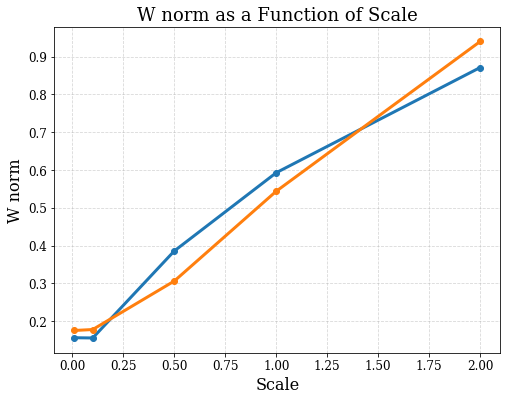

In [51]:
# defining 4 different environments for 4 scales
scales = [0.01, 0.1, 0.5, 1, 2]
slope_val=0.3
w_norms = []

for scale in scales:
    # training with different scale std's
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2,
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : 0.3,
                'slope_high' : 0.3,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : scale}
    
    rank_env = RankingEnv(**env_params)
    # defining both models
    strategic_model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    non_strategic_model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    path_strategic = f"./tests/scales_test_{scale}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = strategic_model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = strategic_model.total_time
    ccp_time = strategic_model.ccp_time
    w, _ = strategic_model.get_wb()
    total.append(total_time)
    ccp.append(ccp_time)
    # we take the L2(=p)-norm of w
    w_norms.append(float(torch.norm(w, p=2)))

    # saving baseline
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')

    # do the same for the non-strategic model
    path_non_strategic = f"./tests/scales_test_{scale}/non_strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training non-strategic model')
    non_strategic_train_metrics, non_strategic_test_metrics = non_strategic_model.fit(path_non_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = non_strategic_model.total_time
    ccp_time = non_strategic_model.ccp_time
    w, _ = non_strategic_model.get_wb()
    total.append(total_time)
    ccp.append(ccp_time)
    # we take the L2(=p)-norm of w
    w_norms.append(float(torch.norm(w, p=2)))

    # saving baseline
    pd.DataFrame(np.array(total)).to_csv(path_non_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_non_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_non_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_non_strategic + '/test_metrics.csv')
    
# plotting an appropriate plot for w as a function of scale
strategic_w_norms=w_norms[::2]
non_strategic_w_norms=w_norms[1::2]
plt.plot(scales, strategic_w_norms, marker='o', label='strategic model')
plt.plot(scales, non_strategic_w_norms, marker='o', label='non-strategic model')
plt.title('W norm as a Function of Scale')
plt.xlabel('Scale')
plt.ylabel('W norm')
plt.grid(True)
plt.show()
        

We expect the non-strategic model to chagne the norm of W less. Meaning is reponds less to the model of the strategic feature change.